In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import scipy
from scipy.stats import mode, norm, lognorm, gamma, skewnorm, expon, beta, weibull_min, cauchy, t, kstest

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

import os
import sys

# I had to do some research to get GPU acceleration on an M4 MBP working. Here is where I landed:
# python 3.9
# tensorflow 2.14.1
# tensorflow-macos 2.14.1
# tensorflow-metal 1.1.0 -- this is the api that lets us use gpu acceleration on apple silicon
#
# The downgraded libraries cause some warnings to pop up, so we silence them with the warnings package

import warnings

from tensorflow.python.keras.legacy_tf_layers.core import dropout

warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, losses

## Sources

These are the research papers that I spent the most time rereading and digging into as I tried to figure out how to tackle the use case in this project. Note that we will use a single digit in square brackets (i.e., [1]), to indicate one of the sources listed here.

1. Noseong Park and Mahmoud Mohammadi and Kshitij Gorde and Sushil Jajodia and Hongkyu Park and Youngmin Kim (2018). Data Synthesis Based on Generative Adversarial Networks. [https://www.vldb.org/pvldb/vol11/p1071-park.pdf]. VLDB

    This paper introduces table-GAN, an approach to deep modeling to create synthetic tabular data through the use of convolutional neural networks (CNNs) and generative adversarial networks (GANs). Note that it was published in the same year as the next paper on TGAN, though it is by different authors. Note that source 2 below references this paper and its tableGAN approach.
    
2. Lei Xu and Kalyan Veeramachaneni (2018). Synthesizing Tabular Data using Generative Adversarial Networks. [https://arxiv.org/abs/1811.11264]. arXiv

    This paper introduces tabular generative adversarial networks (TGANs), a precursor to the CTGAN in the next paper and similar to the previous paper but utilizing recurrent neural networks (RNNs) in place of CNNs.
     
3. Lei Xu and Maria Skoularidou and Alfredo Cuesta-Infante and Kalyan Veeramachaneni (2019). Modeling Tabular Data using Conditional GAN. [https://arxiv.org/abs/1907.00503]. arXiv

    This paper introduces conditional tabular generative adversarial networks (CTGAN), a deep learning conditional GAN that improves, according to the authors, on their approach in the previous paper by introducing a conditional generator to the architecture.

4. Emiliano De Cristofaro (2024). Synthetic Data: Methods, Use Cases, and Risks. [https://arxiv.org/abs/2303.01230]. arXiv

    This paper is a good resource for understanding synthetic data generally.

5. Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

    This dataset comes from the University of California Irvine Machine Learning Repository, is based on 1994 Census data, and allows us to classify if given individuals make more than $50,000 per year. While gleaning insights out of the dataset is not the focus of this project, we do still need a dataset to work with as we test out generating synthetic data. We partially pick this dataset because it shows up in a number of the papers referenced for this project.

6. Alec Radford and Luke Metz and Soumith Chintala (2016). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. [https://arxiv.org/abs/1511.06434]. arXiv 
    
    This paper introduces deep convolutional generative adversarial networks (DCGAN), a GAN architecture that [1] relies on.


## Project Introduction & Introduction to Synthetic Data

My modus operandi is to start projects by finding interesting datasets and building out the other details from there. In this project, we will instead start with an application of deep learning and see if we can get it working on a tried-and-true machine learning dataset. We will try to build a deep learning model that generates synthetic tabular data. Synthetic data is "artificially generated [data] that resemble[s] the actual data -- more precisely, having similar statistical properties" (De Cristofaro, 2024, p. 1).

Synthetic data has been in the air lately due to its proposed use to feed even greater amounts of data into burgeoning artificial intelligence models. This use of synthetic data is focused on increasing the amount of data that is available. If we have 1,000,000 rows of data, we can use a model to learn the ins and outs of that data and then create new synthetic rows to supplement the real ones. We could also use this approach to rebalance classes in the data.

But my original interest in synthetic data was to protect privacy. If we have a dataset that includes personally identifiable information (PII) -- names, social security numbers (SSNs) or other unique identifiers, addresses, emails, dates of birth, etc. -- our first step would be to anonymize that data. One approach here would be to develop an algorithm for assigning an anonymized unique identifier for each unique individual based on the PII. We can feed PII into the model, let the model cluster by unique individuals it identifies based on the PII, and then have the model assign the anonymized identifier to each cluster. We could then drop all PII from the dataset and replace it with the anonymized identifier.

This is a good first step in that it removes data that can identify an individual directly, but we still have a problem. Someone may be able to use, for instance, high school graduation year, high school grade point average, courses taken in high school, race and ethnicity, and gender to reverse engineer who someone is. We cannot anonymize all data, including non-PII data, to reduce this risk since we would have nothing left to run analysis on. But, we can synthesize data. Instead of supplementing real data with synthetic data to increase the number of observations in the dataset, this time we create a dataset that is entirely made up of synthetic data, allowing us to share the synthetic dataset for analysis since it matches the real data's statistical properties while protecting privacy since we are not releasing any rows with real data, so there is no real person to tie any row back to.

There are deeper layers of privacy and security concerns with synthetic data that are in active research. [4] provides a longer summary that serves as a good introduction to these if you are curious about them. For our purposes, and, as we shall see, since we are not able to get far enough into this type of generative modeling to focus on the deeper security implications, we will not go into detail on these for now.




## General Summary

The goal of this project is to understand how deep learning models for synthetic data work, trying to build a model inspired by the research papers. Originally there was a neural network and research paper summary here, but I moved those to the end of the notebook. This project is long enough, so feel free to skip reading those, but I kept them at the end since I needed to spend awhile digging into research papers in order to understand how others have approached this type of modeling.

The difficulty of this type of modeling surprised me. My original thought was to use RNNs to model each row of data as a sequence of features. But, after reading through the research paper, I pivoted to using GANs. The goal is to build a GAN for supervised learning where we provide labels for real and synthetic data and try to train the generator to produce synthetic data associated with a label for real data that can trick the discriminator, and we try to train the discriminator to correctly learn how to classify the real and synthetic data it sees. As is typical with a GAN, these two networks compete with each other, and we hope in the end tha the generator wins out over a well-tuned discriminator.

The research papers spend a good chunk of time talking about how to preprocess tabular data of different types. We need a strategy to combine continuous data with categorical data. There are more details on the complexity here in the research paper summaries at the end of the notebook, but we do not include any of the more advanced preprocessing in the papers during this iteration of the project, though I suspect we would need to use some of those in order to improve GAN performance later during modeling.

Speaking of modeling, the papers lean into three approaches. The first is sampling from a joint probability distribution where each feature is treated as its own random variable. We show how this works later when we treat each feature as independent, but the trick here is that the features are not independent, so we need to also find the joint probability distribution between the features, a task that is much more complicated than it seems as first and that we leave for future iterations of the project.

Each of the papers reviews standard and custom loss functions. For me, implementing these custom loss function is probably the hardest part of the papers. We will stick with using binary cross-entropy during our training since we pass labels for real and fake data, so we can treat our model training as a classification problem. I got this idea from the Tensorflow DCGAN docs referenced later.

The research papers do however speak about evaluation methods that we include in this project. These methods speak to how we compare a synthetic dataset to the real data and determine how similar they are. The first is taking statistical properties for the matching pair of features across both datasets. We take the mean and standard deviation of each feature in both datasets and compare them. Ideally we would automate this by setting some threshold $\epsilon$ and considering the synthetic data real enough when it falls within that threshold. This threshold then becomes a type of parameter that we can use to create more or less similar synthetic data.

The second evaluation metric is machine learning score similarity. In this method, we train a classification model on the real and synthetic datasets and compare the resulting performance on a held-out test set. If the performance against both datasets results in similar enough classification performance, then we can consider the synthetic data real enough.

We will use both of these evaluation metrics later during modeling, though, as we will see, we end up getting stuck on GAN performance, but it is good to have these evaluation methods ready.

So where does that all leave us? Well, first, if this seems complicated to you, then we are in agreement about that. One thing I have learned reading a number of research papers related to synthetic data generation is that no single paper tends to build its solutions from scratch or first principles. There are often chains of building on top of one or more approaches in other papers. We will not get nearly as far in modeling as I hoped, but this project does provide a good foundation from which to start to expand into the more complicated approaches to tabular synthetic data generation mentioned in the papers, and that is a good place to end up for this iteration of the project.

But, in order to get there, we need to run some exploratory data analysis (EDA) on the dataset we will be working with.



## Preprocessing and EDA

Repeated from above, this dataset comes from the University of California Irvine Machine Learning Repository, is based on 1994 Census data, and allows us to classify if given individuals make more than \$50,000 per year. It has 48,842 total records, 32,561 in `adult.data` and 16,281 in `adult.test`, so a $\frac{2}{3}$ to $\frac{1}{3}$ train-test split. We will combine these and later create our own train-test split. There has been some minor preprocessing already done on the data that we are okay with, though we will explore the data for further preprocessing.

There are 14 features and 1 target. This dataset lends itself to binary classification predicting if a row makes more or less than $50,000 in income. However, since our task is generating synthetic data, our preprocessing and EDA will focus on getting the data ready for generative modeling. For example, we should keep an eye out for multimodal continuous data and class imbalance in discrete variables in particular since those came up in all three of the papers above.

Pulling from the data dictionary in `adult.names` and from the UCI link in the Sources section above, here is a quick summary of the base features:

- `age`: numeric
- `workclass`: 8 nominal levels representing type of work such as private, federal government, local government, etc.
- `fnlwgt`: numeric combination of different Census Bureau weights; we will drop this since we are not extrapolating to population estimates
- `education`: 16 ordinal levels representing educational attainment
- `education-num`: Looks like a numeric representation of `education`
- `marital-status`: 7 nominal levels
- `occupation`: 14 nominal levels
- `relationship`: 6 nominal levels
- `race`: 5 nominal levels
- `sex`: binary
- `capital-gain`: numeric
- `capital-loss`: numeric
- `hours-per-week`: numeric hours worked per week
- `native-country`: 41 nominal levels
- `income`: binary target feature


In [3]:
col_names = [
    'age'
    , 'workclass'
    , 'fnlwgt'
    , 'education'
    , 'education-num'
    , 'marital-status'
    , 'occupation'
    , 'relationship'
    , 'race'
    , 'sex'
    , 'capital-gain'
    , 'capital-loss'
    , 'hours-per-week'
    , 'native-country'
    , 'income'
]

# Source CSVs have spaces after commas, so we drop them with the skipinitialspace param
df = pd.concat([
    pd.read_csv(
        './data/adult.data'
        , names=col_names
        , skipinitialspace=True
    )
    , pd.read_csv(
        './data/adult.test'
        , names=col_names
        , skipinitialspace=True
        , skiprows=1
    )
# We will drop fnlwgt here since we do not use it
]).drop(columns=['fnlwgt']).reset_index(drop=True)

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns\n\n')
df.info()

The dataset has 48,842 rows and 14 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   education-num   48842 non-null  int64 
 4   marital-status  48842 non-null  object
 5   occupation      48842 non-null  object
 6   relationship    48842 non-null  object
 7   race            48842 non-null  object
 8   sex             48842 non-null  object
 9   capital-gain    48842 non-null  int64 
 10  capital-loss    48842 non-null  int64 
 11  hours-per-week  48842 non-null  int64 
 12  native-country  48842 non-null  object
 13  income          48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


No surprises here. The datatypes line up with what we are expecting to see based on the dictionary. Next we will check for nulls and invalid values.

In [4]:
print(f'There are {df.isnull().sum().sum()} nulls in the source dataset')
print()
print()

for col in df:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')


There are 0 nulls in the source dataset


age: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]

workclass: ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

education: ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college']

education-num: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

marital-status: ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']

occupation: ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handle

Most of the values look okay. We do need to clean up ?s and combine the `income` categories that differ by having a period. Aside from that, the range of values are what we expect to see for each feature, so we do not need to drop rows based on invalid values. We will test for outliers with visualizations below.

`adult.names` tells us that the curators of the data replaced unknowns with '?', and we see no direct nulls. We can see the ?s in `workclass`, `occupation`, and `native-country`.

In an interesting turn, we are less interested in what specific factor levels mean for this project. We are concerned with their distributions and in checking that any combinations of values are valid, but, for example, while `Married-AF-spouse` may mean married to a spouse in the air force compared to `Married-civ-spouse` possibly meaning married to a civilian spouse, it actually is not important for us to clarify or confirm.

The final issue is in `income` and is that each category shows up twice: once with a period and once without, so, for example, having both '>50K.' and '>50K'.

In [5]:
print(
    f"There are {df[df.isin(['?']).any(axis=1)].shape[0]:,} rows with ?s, "
    f"{df[df.isin(['?']).any(axis=1)].shape[0]/df.shape[0]:,.3f} of the total rows in the dataset"
)
print()
print()
 
# Dropping based on the isin() condition is losing more rows than expected, so we drop this way instead
df = df[
    (df['workclass'] != '?')
    & (df['occupation'] != '?')
    & (df['native-country'] != '?')
]

# Remove the periods
df.loc[df['income'] == '<=50K.', 'income'] = '<=50K'
df.loc[df['income'] == '>50K.', 'income'] = '>50K'

print(f'The are {df.shape[0]:,} rows remaining in the dataframe')
print()
for col in df[['workclass', 'occupation', 'native-country', 'income']]:
    print(f'{col}: {np.sort(df[col].unique()).tolist()}\n')


There are 3,620 rows with ?s, 0.074 of the total rows in the dataset


The are 45,222 rows remaining in the dataframe

workclass: ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']

occupation: ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']

native-country: ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France', 'Germany', 'Greece', 'Guatemala', 'Haiti', 'Holand-Netherlands', 'Honduras', 'Hong', 'Hungary', 'India', 'Iran', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Laos', 'Mexico', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto-Rico', 'Scotland', 'South', 'Taiwan', 'Thailand', 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yug

Only 7% of the rows have missing values. The complexity of this project is focused on modeling, so, to avoid adding more layers of complication here, we will drop the rows with missing values, keeping 45,222 left for us to experiment with.

Next we check out the single ordinal feature.


In [6]:
df[['education', 'education-num']].drop_duplicates().sort_values(by='education-num')


,education,education-num
224,Preschool,1
416,1st-4th,2
56,5th-6th,3
15,7th-8th,4
6,9th,5
219,10th,6
3,11th,7
415,12th,8
2,HS-grad,9
10,Some-college,10


We see that `education-num` is, in fact, ordinal -- matching what we see in the data dictionary -- corresponding to `education` with higher numeric values equivalent to further education. The dataset may have a numeric encoding for `education` because it is the only ordinal categorical feature. We will want to make sure to keep one of these during modeling later so we have an ordinal feature for testing.

### Continuous Features

The research papers mention that one approach to generating synthetic data is to sample from a joint distribution where we know the distribution for the random variable in each feature. This means we need to begin identifying distributions for numeric data. We will add that step in during EDA here, though we should note that this process can be difficult. Real world data often does not fit cleanly into known distributions.

#### Distribution Fitting

We will use two approaches for determining distributions: the Kolmogorov-Smirnov (KS) test and visual inspection.

For our use of the KS test, it checks if the data comes from the specified distribution. We will fit different distributions to the data to estimate distribution parameters. We then plot the probability density functions (PDFs) on top of the histograms. For the KS test, instead of using PDFs on top of histograms to compare the fits, we instead sample from the distributions and compare the shape of the sampled data to that of the real data. A lower KS test statistic corresponds to less of a difference, meaning we have a better fit.

The KS test also gives p-values with the following hypotheses:
- $H_0$: data comes from the specified distribution
- $H_1$: data does not come from the specified distribution

As a teaser, all of our tests end up with large KS test statistics and p-values much, much smaller than 0.05, so we do not find sufficient distributions. That does not mean that the distributions are incorrect for the data. It just means that with the initial KS test and the process we are using, we do not have strong statistical evidence to select one of the distributions.

For the visual inspection, we look at the PDF curves overlaid on top of the empirical histograms to determine fit.

This process is okay for what we need it to do for now. Our goal is to understand the data better, not to find the perfect distributional fit. While sampling from a joint distribution where we have modeled each feature as a random variable with a known parametric distribution is one approach to generating synthetic data, we are looking at deep learning solutions, so we do not want to spend too much time refining the distribution fitting process and take away from the other modeling.


In [7]:
# Returns basic measures of central tendency
def gimme_some_averages(col, colname):
    print(f'Mean of {colname}: {np.mean(col):.2f}')
    print(f'Median of {colname}: {np.median(col)}')
    print(f'Mode of {colname}: {mode(col)}')
    print()


Mean of age: 38.55
Median of age: 37.0
Mode of age: ModeResult(mode=36, count=1283)



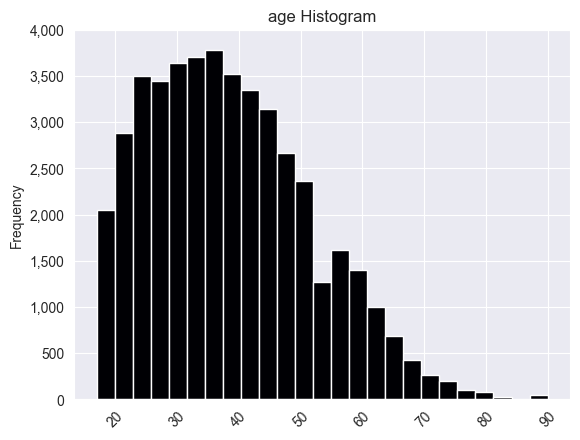

In [8]:
ax = df['age'].plot(
    kind='hist'
    , bins=25
    , title='age Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages(df['age'], 'age')


`age` has a bit of a right skew to it. The mean and median are relatively close, and the highest age is a little over twice as much as both. We only see one mode.

We have a number of theoretical distributions that appear right skewed when compared to a normal distribution. We will start by checking against the distributions in `gimme_some_age_distributions`. Since we will not get a clear winner, we will also try handling outliers to see if that clarifies the underlying distribution.

In [9]:
# Fits distributions, plots PDFs of those fitted distributions, and runs and outputs KS tests
def gimme_some_age_distributions(col, nbins):
    params_expon = expon.fit(col)
    params_norm = norm.fit(col)
    params_skewnorm = skewnorm.fit(col)
    params_lognorm = lognorm.fit(col)
    params_t = t.fit(col)
    params_gamma = gamma.fit(col)
    params_beta = beta.fit(col)
    params_weibull = weibull_min.fit(col)
    params_cauchy = cauchy.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    plt.plot(x, norm.pdf(x, *params_norm), color='g', label='Normal')
    plt.plot(x, skewnorm.pdf(x, *params_skewnorm), color='b', label='Skewed Normal')
    plt.plot(x, lognorm.pdf(x, *params_lognorm), color='c', label='LogNormal')
    plt.plot(x, t.pdf(x, *params_t), color='m', label="Student's T")
    plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma')
    plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta')
    plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull')
    plt.plot(x, cauchy.pdf(x, *params_cauchy), color='tab:pink', label='Cauchy')
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['norm', *[*kstest(df['age'], 'norm', params_norm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['skewnorm', *[*kstest(df['age'], 'skewnorm', params_skewnorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['lognorm', *[*kstest(df['age'], 'lognorm', params_lognorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['t', *[*kstest(df['age'], 't', params_t)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['cauchy', *[*kstest(df['age'], 'cauchy', params_cauchy)]], (-1, 3)), columns=col_names)
        ], axis=0
    )

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='pvalue', ascending=False)


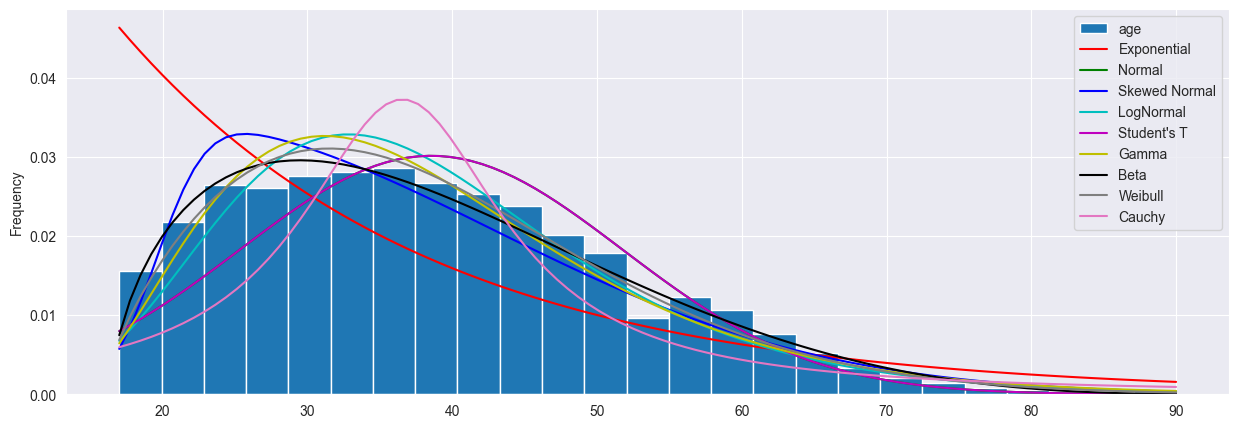

  distribution  statistic         pvalue
0         beta   0.036362   2.193863e-52
0      weibull   0.037578   6.403220e-56
0      lognorm   0.043856   5.100988e-76
0        gamma   0.048546   4.673454e-93
0            t   0.060890  3.419930e-146
0         norm   0.060896  3.192619e-146
0     skewnorm   0.069555  1.116308e-190
0        expon   0.164534   0.000000e+00
0       cauchy   0.130859   0.000000e+00




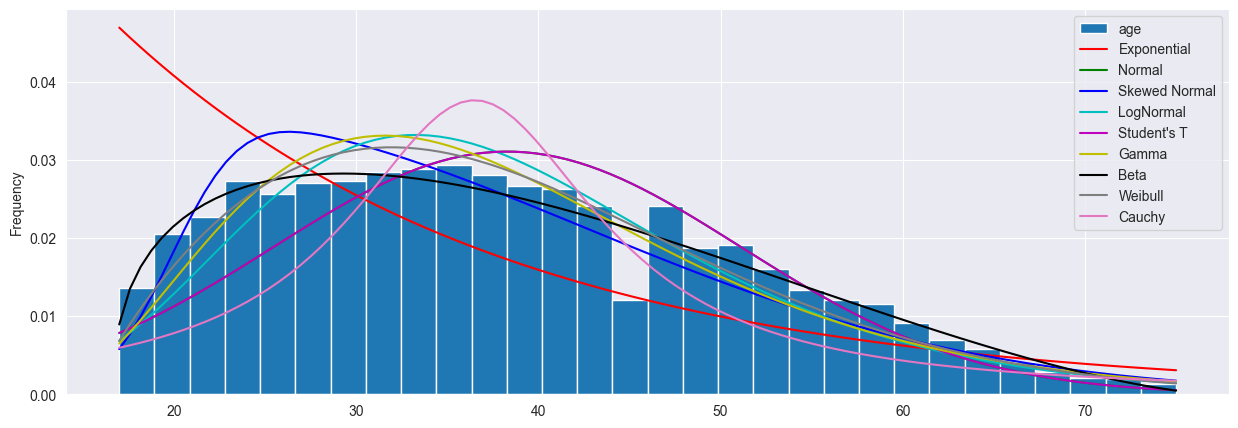

  distribution  statistic         pvalue
0         beta   0.031872   2.408832e-40
0      weibull   0.042691   4.686997e-72
0      lognorm   0.048334   2.996781e-92
0        gamma   0.053188  1.251845e-111
0            t   0.058579  2.470284e-135
0         norm   0.058582  2.409088e-135
0     skewnorm   0.073978  1.124374e-215
0        expon   0.168465   0.000000e+00
0       cauchy   0.130183   0.000000e+00


In [10]:
print(gimme_some_age_distributions(df['age'], 25))
print()
print()

# Removing outliers above 1.5 times the interquartile range
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
print(gimme_some_age_distributions(df.loc[df['age'] < upper_limit, 'age'], 30))



Cutting the outliers improves the KS statistic but does not change the overall distribution fitting story, so we will keep the outliers in. We reject the null hypothesis for all the KS tests, indicating that none of these distributions capture the actual data.

Visually, the beta distribution looks as good as a couple of others, and the beta distribution has the smallest KS statistic, so we can stick with this distribution for this feature. We will snag the parameters for the beta distribution so we can sample from it later during modeling.

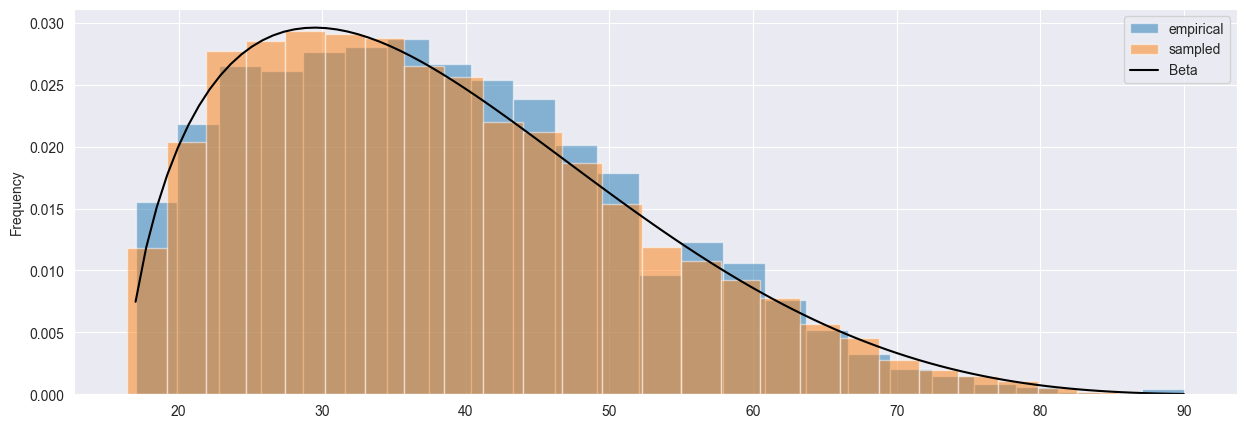

Beta distribution parameters are:
alpha=1.6420
beta=4.2078
location=16.3570
scale=78.6749


In [11]:
params_age = beta.fit(df['age'])

df['age'].plot(
    kind='hist'
    , bins=25
    , density=True
    , figsize=(15, 5)
    , alpha=0.5
    , label='empirical'
)
plt.hist(
    beta.rvs(a=params_age[0], b=params_age[1], loc=params_age[2], scale=params_age[3], size=10000)
    , bins=25
    , density=True
    , alpha=0.5
    , label='sampled'
)
xs = np.linspace(min(df['age']), max(df['age']), 100)
plt.plot(xs, beta.pdf(xs, *params_age), color='k', label='Beta')
plt.legend()
plt.show()

print(
    f'Beta distribution parameters are:\nalpha={params_age[0]:.4f}\nbeta={params_age[1]:.4f}\n'
    f'location={params_age[2]:.4f}\nscale={params_age[3]:.4f}'
)


With that, we have the info we need from `age`. Next we move onto `capital-gain`.

Mean of capital-gain: 1101.43
Median of capital-gain: 0.0
Mode of capital-gain: ModeResult(mode=0, count=41432)



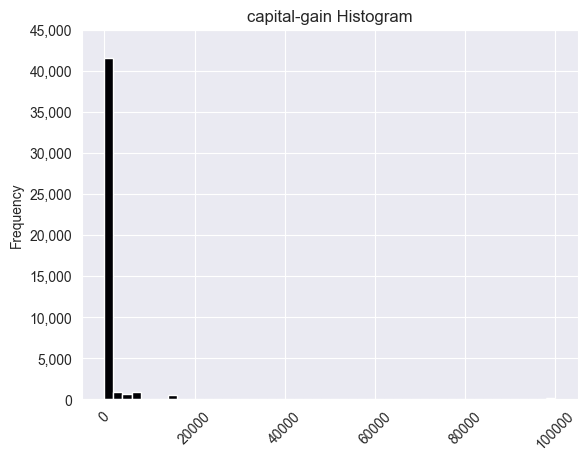

In [12]:
ax = df['capital-gain'].plot(
    kind='hist'
    , bins=50
    , title='capital-gain Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages(df['capital-gain'], 'capital-gain')


The outliers for `capital-gain` are more pronounced than what we saw in `age`. The median and mode are both 0, but the mean is much higher. This is due to the high values moreso than due to the amount of non-zero values. This plot already looks problematic. Any sort of sampling we do is likely to return just 0s.

In [13]:
print(
    f"There are {df.loc[df['capital-gain'] != 0, 'capital-gain'].shape[0]:,} rows with non-zero values for capital-gain, "
      f"{df.loc[df['capital-gain'] != 0, 'capital-gain'].shape[0] / df.shape[0]:0.2f} of the total number of rows\n\n"
)
df['capital-gain'].value_counts().sort_index()


There are 3,790 rows with non-zero values for capital-gain, 0.08 of the total number of rows




capital-gain
0        41432
114          8
401          2
594         42
914         10
         ...  
25236       14
27828       56
34095        4
41310        3
99999      229
Name: count, Length: 121, dtype: int64


About 92% of the data has 0s for `capital-gain`, a severe imbalance between values for this feature. We cannot drop 92% of the dataset because we lose too much data. We could look at dropping the 8% that is non-zero, but then we have a feature of all 0s -- not a very informative feature -- and it is useless in terms of modeling or predictive power. The data looks like it has already been winsorized for everything above 99,999. We could trim that cutoff much lower, but it does not solve the core imbalance issue.

We will try to fit distributions to the data, though the heavy imbalance of 0s makes this difficult.


In [14]:
def gimme_some_capital_gain_distributions(col, nbins):
    params_expon = expon.fit(col)
    # params_gamma = gamma.fit(col)
    # params_beta = beta.fit(col)
    # params_weibull = weibull_min.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    # plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma', density=True)
    # plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta', density=True)
    # plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull', density=True)
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
    ], axis=0
)

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='pvalue', ascending=False)


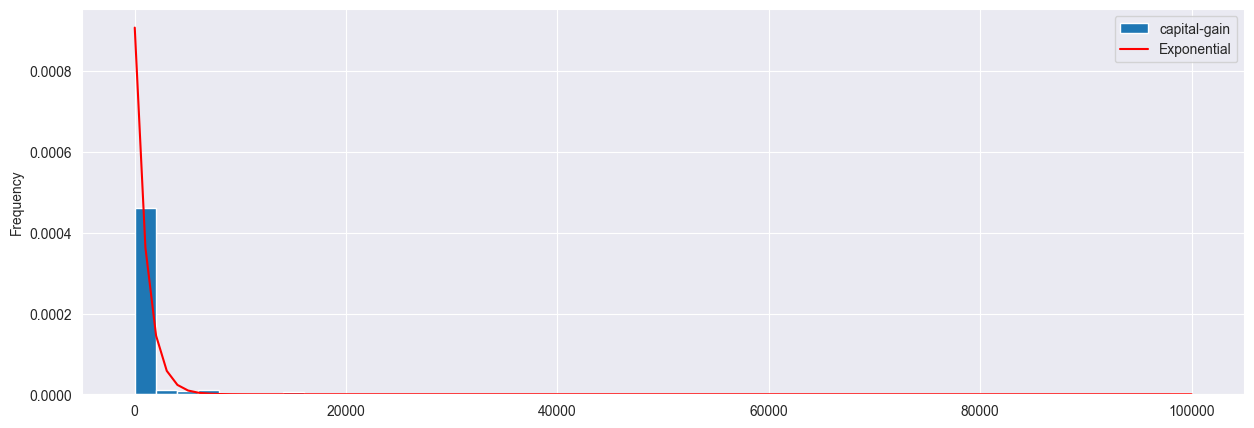

,distribution,statistic,pvalue
0,expon,0.92841,0.0


In [15]:
gimme_some_capital_gain_distributions(df['capital-gain'], 50)


I honestly do not know the best way to try to model this feature. The imbalance throws off model fitting for all the distributions we are testing. The closest fit seems to be an exponential distribution, but, as we see in the table with the KS test output, the KS statistic is pretty high. 

We will consider dropping this feature. We are unlikely to find a known parametric distribution that we can sample from for it. We could look at using nonparametric models or even adding more complexity with ANNs, but, as is a theme for this project, I want to be careful in terms of scope, and trying to accommodate a continuous feature with sever imbalance pulls us away from our core focus on generative modeling. I do suspect that this feature would end up being important for predictive power due to individuals who have capital gains being ones who have higher incomes.

Similar to above, we can proceed forward with a proof-of-concept of modeling with this distribution knowing that this one is problematic and that we would need to return here if we wanted to include this feature.

Next we will check out `capital-loss` to see if it shares the same issues as `capital-gain`.


Mean of capital-loss: 88.60
Median of capital-loss: 0.0
Mode of capital-loss: ModeResult(mode=0, count=43082)



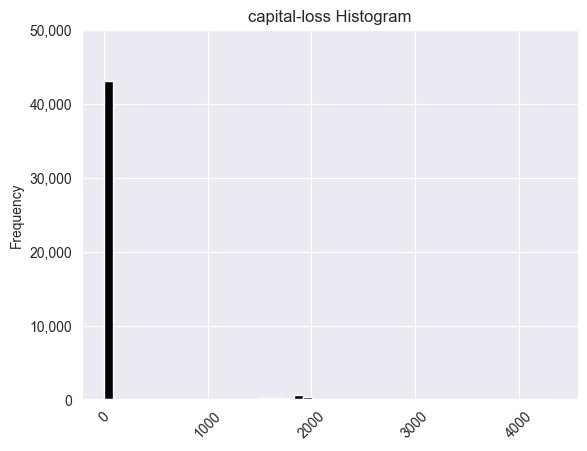

In [16]:
ax = df['capital-loss'].plot(
    kind='hist'
    , bins=50
    , title='capital-loss Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages(df['capital-loss'], 'capital-loss')


We see a similar plot to what we saw in `capital-gain`. Most values are 0s. Again, this is likely to cause problems for fitting a parametric distribution to the empirical data.

In [17]:
print(
    f"There are {df.loc[df['capital-loss'] != 0, 'capital-loss'].shape[0]:,} rows with non-zero values for capital-loss, "
    f"{df.loc[df['capital-loss'] != 0, 'capital-loss'].shape[0] / df.shape[0]:0.2f} of the total number of rows\n\n"
)
df['capital-loss'].value_counts().sort_index()


There are 2,140 rows with non-zero values for capital-loss, 0.05 of the total number of rows




capital-loss
0       43082
155         1
213         5
323         5
419         1
        ...  
3175        2
3683        2
3770        4
3900        2
4356        1
Name: count, Length: 97, dtype: int64

In [18]:

def gimme_some_capital_loss_distributions(col, nbins):
    params_expon = expon.fit(col)
    # params_gamma = gamma.fit(col)
    # params_beta = beta.fit(col)
    # params_weibull = weibull_min.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    # plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma', density=True)
    # plt.plot(x, beta.pdf(x, *params_beta), color='k', label='Beta', density=True)
    # plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull', density=True)
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['beta', *[*kstest(df['age'], 'beta', params_beta)]], (-1, 3)), columns=col_names)
        # , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
    ], axis=0
)

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='pvalue', ascending=False)


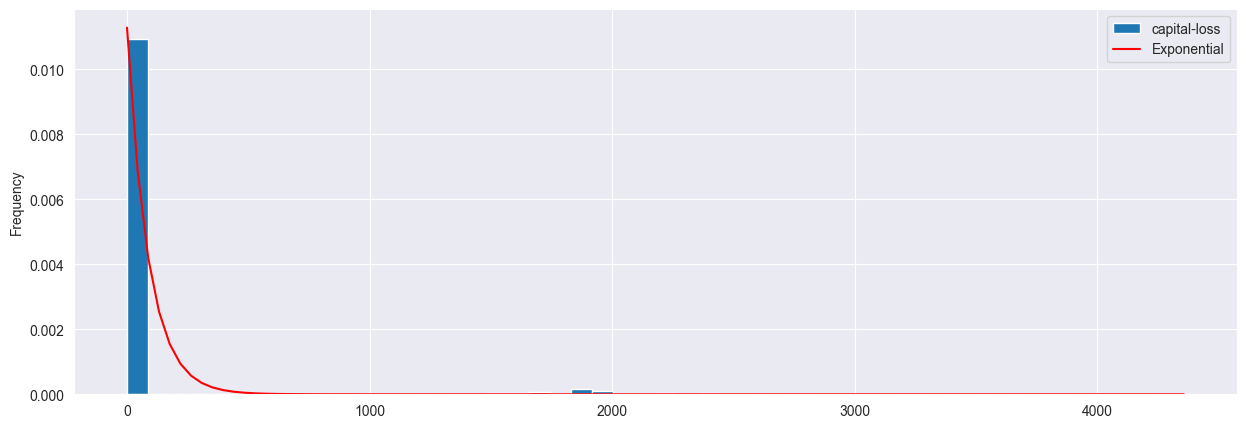

,distribution,statistic,pvalue
0,expon,0.451074,0.0


In [19]:
gimme_some_capital_loss_distributions(df['capital-loss'], 50)


We do see similar issues with `capital-loss`. Again, most of the distributions we are testing do not fit the empirical data well. Going through them one-by-one does not help the situation -- even after toying around to try and get the fits working. Some fail because of the 0 values. Others return 0.0 p-values, indicating that that distribution does not capture the empirical data. All of my thoughts for `capital-gain` apply here, including my hypothesis that this feature is important for predictive power due to individuals with capital losses also being those who have higher incomes, though we will struggle to find a parametric distribution we can easily sample from to generate synthetic values for this feature.

`capital-loss` does have fewer non-zero rows than `capital-gain`. The range for the losses is also smaller than the range for the gains, and the gains have the winsorized cutoff at 99,999, so the actual range for gains is wider.

Our strategy for `capital-loss` is the same as for the previous feature in that we will leave it out for models in which we need to provide distributions ahead of time.

Next we will look at the final numeric feature.

Mean of hours-per-week: 40.94
Median of hours-per-week: 40.0
Mode of hours-per-week: ModeResult(mode=40, count=21358)



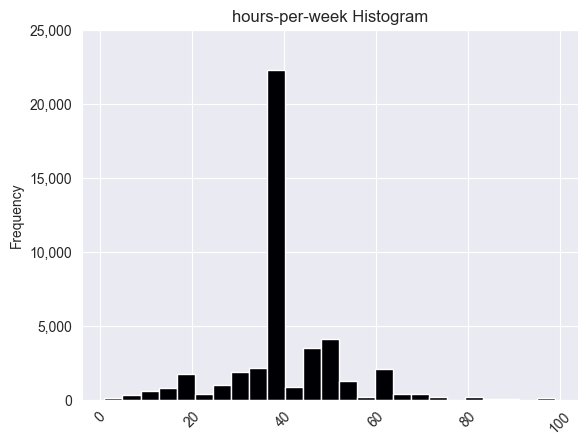

In [20]:
ax = df['hours-per-week'].plot(
    kind='hist'
    , bins=25
    , title='hours-per-week Histogram'
    , rot=45
    , xlabel=None
    , cmap='magma'
)

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_averages(df['hours-per-week'], 'hours-per-week')


`hours-per-week` looks sort of normal-ish with a big spike around 40 and longer tails. The mean, median, and mode are all in the same ballpark, though the mean is a slight bit higher, indicating a bit of right skew, which we can see visually. This may be capturing the fact that a significant-enough number of individuals work around 50-55 hours per week in particular.

It is a stretch, but we may be able to consider this multimodal with the 40ish and 50ish values as the two modes, if we decide to test out explicitly handling multi-modal continuous data during modeling.

In [21]:

def gimme_some_hours_per_week_distributions(col, nbins):
    params_expon = expon.fit(col)
    params_norm = norm.fit(col)
    params_skewnorm = skewnorm.fit(col)
    params_lognorm = lognorm.fit(col)
    params_t = t.fit(col)
    params_gamma = gamma.fit(col)
    params_weibull = weibull_min.fit(col)
    params_cauchy = cauchy.fit(col)

    # We use this to create 100 values between the min and max of the col param to make sure
    # the PDFs and plots match the x range of the actual data in the column
    x = np.linspace(min(col), max(col), 100)

    # Plot the histogram for the col param with the PDF lines for each distribution on top
    col.plot(
        kind='hist'
        , bins=nbins
        , density=True
        , figsize=(15, 5)
    )
    plt.plot(x, expon.pdf(x, *params_expon), color='r', label='Exponential')
    plt.plot(x, norm.pdf(x, *params_norm), color='g', label='Normal')
    plt.plot(x, skewnorm.pdf(x, *params_skewnorm), color='b', label='Skewed Normal')
    plt.plot(x, lognorm.pdf(x, *params_lognorm), color='c', label='LogNormal')
    plt.plot(x, t.pdf(x, *params_t), color='m', label="Student's T")
    plt.plot(x, gamma.pdf(x, *params_gamma), color='y', label='Gamma')
    plt.plot(x, weibull_min.pdf(x, *params_weibull), color='tab:grey', label='Weibull')
    plt.plot(x, cauchy.pdf(x, *params_cauchy), color='tab:pink', label='Cauchy')
    plt.legend()
    plt.show()

    col_names = ['distribution', 'statistic', 'pvalue']

    # The asterisks unpack list elements, an alternative way to combine the name of a distribution and each of the two
    # kstest() outputs into a single 3-element list that we reshape to an array having one row and three columns
    df_dist = pd.concat([
        pd.DataFrame(np.reshape(['expon', *[*kstest(df['age'], 'expon', params_expon)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['norm', *[*kstest(df['age'], 'norm', params_norm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['skewnorm', *[*kstest(df['age'], 'skewnorm', params_skewnorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['lognorm', *[*kstest(df['age'], 'lognorm', params_lognorm)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['t', *[*kstest(df['age'], 't', params_t)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['gamma', *[*kstest(df['age'], 'gamma', params_gamma)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['weibull', *[*kstest(df['age'], 'weibull_min', params_weibull)]], (-1, 3)), columns=col_names)
        , pd.DataFrame(np.reshape(['cauchy', *[*kstest(df['age'], 'cauchy', params_cauchy)]], (-1, 3)), columns=col_names)
    ], axis=0
    )

    df_dist['statistic'] = pd.to_numeric(df_dist['statistic'])
    df_dist['pvalue'] = pd.to_numeric(df_dist['pvalue'])

    return df_dist.sort_values(by='statistic', ascending=True)


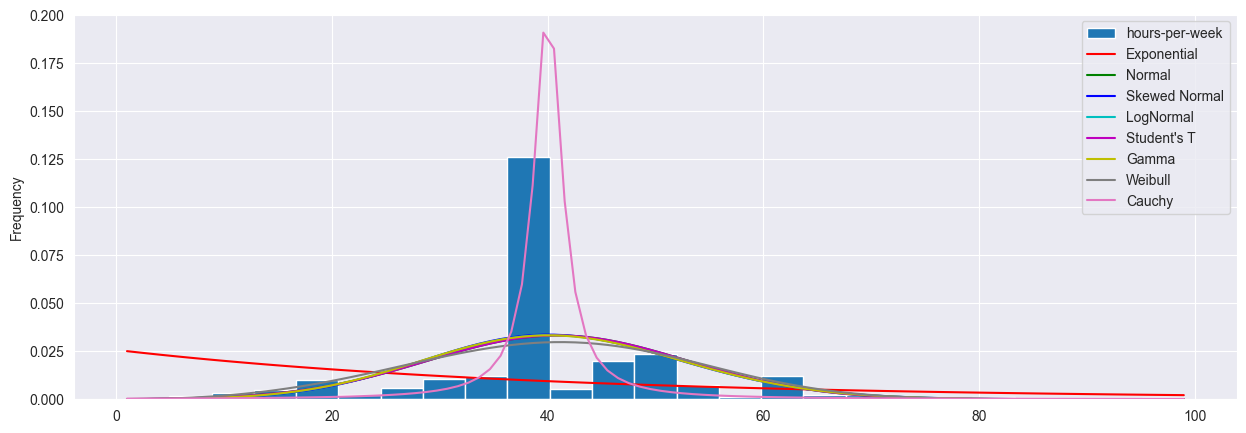

,distribution,statistic,pvalue
0,weibull,0.118331,0.0
0,gamma,0.138964,0.0
0,lognorm,0.140824,0.0
0,skewnorm,0.143108,0.0
0,norm,0.143960,0.0
0,t,0.143960,0.0
0,expon,0.336547,0.0
0,cauchy,0.365733,0.0


In [22]:
gimme_some_hours_per_week_distributions(df['hours-per-week'], 25)

Not surprisingly, the distributions return 0.0 for p-values, again indicating that none of them fit the data well. Looking at the plots, most of the distributions have similar PDF lines, the exponential and Cauchy distributions excepted. The Cauchy distribution captures the spike around 40 better than the rest, but the other distributions, minus the exponential, capture the non-40-ish values better.

There is a question here as to if we want to capture that spike around 40 or if we want to downplay the spike and capture the remaining shape. We will go with the latter. The Weibull has the lowest KS test statistic, so we will stick with the Weibull distribution.

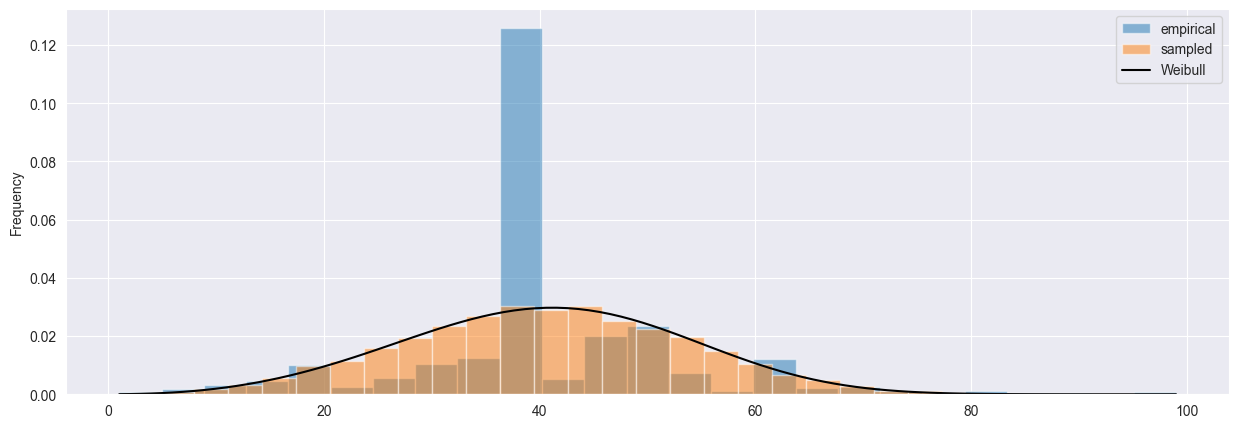

Weibull distribution parameters are:
shape=3.5979
location=-1.2358
scale=46.4293


In [23]:
params_hours_per_week = weibull_min.fit(df['hours-per-week'])

df['hours-per-week'].plot(
    kind='hist'
    , bins=25
    , density=True
    , figsize=(15, 5)
    , alpha=0.5
    , label='empirical'
)
plt.hist(
    weibull_min.rvs(c=params_hours_per_week[0], loc=params_hours_per_week[1], scale=params_hours_per_week[2], size=10000)
    , bins=25
    , density=True
    , alpha=0.5
    , label='sampled'
)
xs = np.linspace(min(df['hours-per-week']), max(df['hours-per-week']), 100)
plt.plot(xs, weibull_min.pdf(xs, *params_hours_per_week), color='k', label='Weibull')
plt.legend()
plt.show()

print(
    f'Weibull distribution parameters are:\nshape={params_hours_per_week[0]:.4f}\n'
    f'location={params_hours_per_week[1]:.4f}\nscale={params_hours_per_week[2]:.4f}'
)


This should be good for the `hours-per-week` feature. We have a first pass at a fitted distribution. It misses the major spike around 40, but it captures the overall shape of the rest of the data, and it seems to capture the ends of the data well enough.

In summary for the continuous features, we have one feature that is possibly multimodal, though the spike in the center is pretty significant and outweighs the remaining values. We have two features with a huge imbalance of 0s. We have two features with proposed distributions we can at least start to play with in modeling. We do have some outliers that we may want to clean up later, but I am curious how the modeling will handle the features as-is. We can always drop extreme values later if needed.

One thing that occurs to me after exploring the features is that the difficulty in finding clear distributions can be a boon for this project. Real world data is messy. It is reasonable to have features such as `capital-gain` and `capital-loss` where most rows are 0s but the non-zero values are significant. All of this is to say that while we spent awhile exploring the numeric features and deciding to leave most changes alone for now until we get into modeling and the feedback we receive there, this is a good dataset to test out with deep learning to see if it can adequately capture these complicated data, and we are able to start with a subset of features and expand from there depending on how modeling goes.

### Categorical Features

There are a couple of considerations as we jump into exploring the categorical features. We have twice as many categorical features as numeric features, ignoring the target `income` feature, and we may want to balance out continuous and categorical features.

We want to keep the binary `sex` feature since it is our only two-class feature aside from the target.

We want to keep an eye out for anything that looks abnormal in the coming visualizations, but we want to keep a particular focus on class imbalance since it comes up in the papers as a known issue for synthetic tabular data generation. We are not sure yet if this project will have the scope to cover handling severe class imbalance, so it may be safer to remove features that show that imbalance.


In [24]:
# Utility function to display counts and percentages in tabular format
def gimme_some_counts(col):
    df_counts = pd.DataFrame(
        col.value_counts()
    )
    df_counts['pct'] = np.round(df_counts['count']/len(col), 3)
    return df_counts

,count,pct
workclass,,
Private,33307,0.737
Self-emp-not-inc,3796,0.084
Local-gov,3100,0.069
State-gov,1946,0.043
Self-emp-inc,1646,0.036
Federal-gov,1406,0.031
Without-pay,21,0.000


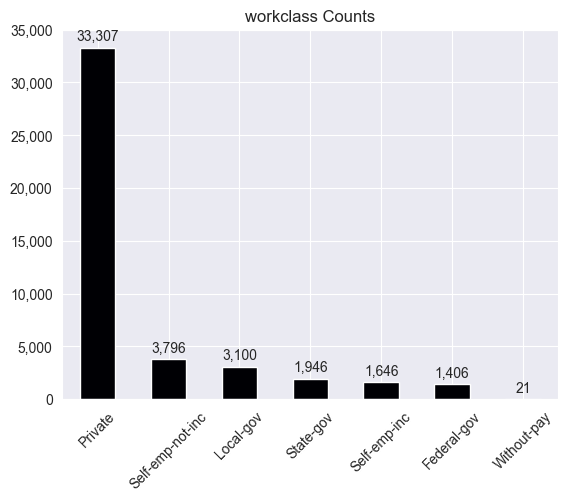

In [25]:
ax = df['workclass'].value_counts().plot(
    kind='bar'
    , title='workclass Counts'
    , rot=45
    , cmap='magma'
)
# Not sure why these plots require removing x labels separately, but at least it works
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['workclass'])


And our first categorical feature has some hefty imbalance. `Private` and `Without-pay` are over- and underrepresented respectively. These both make sense in terms of meaning. `workclass` might be a good feature to explore for handling imbalanced discrete features as described in paper [3] earlier. But, the process described earlier pulls one row from each class in order to keep the number of rows per class equal, avoiding the imbalance issues, but that means we can only pull up to 21 rows in total if we include `Without-pay`, a number that is likely too small to be practical. We will keep this feature in our back pocket as we check if others may be easier to work with.

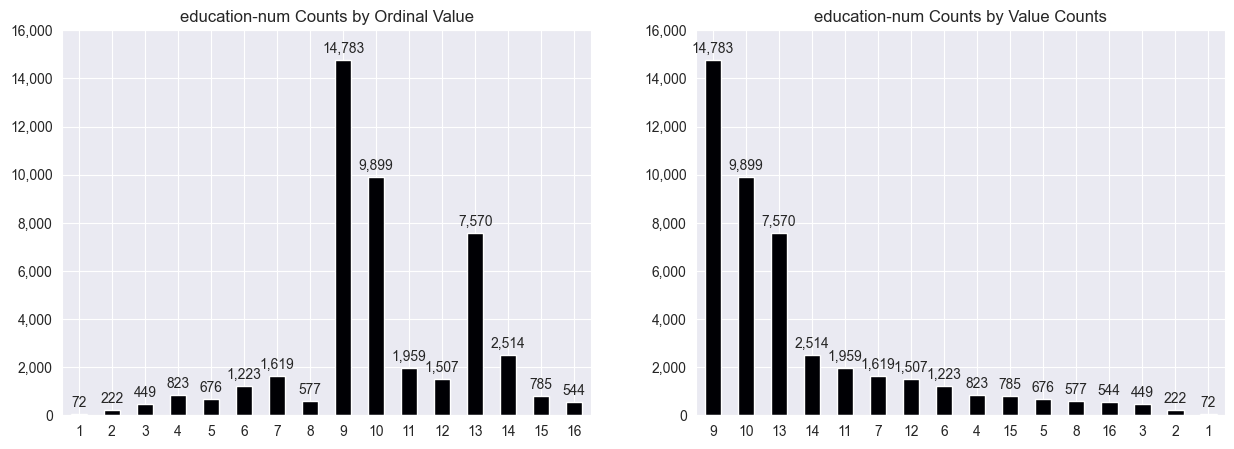

,count,pct
education-num,,
9,14783,0.327
10,9899,0.219
13,7570,0.167
14,2514,0.056
11,1959,0.043
7,1619,0.036
12,1507,0.033
6,1223,0.027
4,823,0.018


In [26]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

ax = df['education-num'].value_counts().sort_index().plot(
    kind='bar'
    , title='education-num Counts by Ordinal Value'
    , rot=0
    , cmap='magma'
    , ax=axes[0]
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


ax = df['education-num'].value_counts().plot(
    kind='bar'
    , title='education-num Counts by Value Counts'
    , rot=0
    , cmap='magma'
    , ax=axes[1]
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

plt.show()

gimme_some_counts(df['education-num'])


`education-num` levels:
- 1: Preschool
- 2: 1st-4th
- 3: 5th-6th
- 4: 7th-8th
- 5: 9th
- 6: 10th
- 7: 11th
- 8: 12th
- 9: HS-grad
- 10: Some-college
- 11: Assoc-voc
- 12: Assoc-acdm
- 13: Bachelors
- 14: Masters
- 15: Prof-school
- 16: Doctorate

`education-num` is our only ordinal feature, though it too has some significant class imbalance, and it has quite a number of classes. Since it is ordinal, we do not need to one-hot encode it, and we prefer `education-num` to `education` since we do not need to apply the extra encoding step. The papers do not speak about handling ordinal features specifically. If we treat these levels as different classes (as we should), then we have a class imbalance problem, so we could test out techniques to handle this from [3]. Despite the imbalance, this is a good feature to keep as it is our only ordinal feature.

It is not surprising that the most common classes are high school graduate, some college, and bachelor's degree. We expect to see positive correlation with this feature and `income` due to those with higher levels of education typically having higher incomes.



,count,pct
marital-status,,
Married-civ-spouse,21055,0.466
Never-married,14598,0.323
Divorced,6297,0.139
Separated,1411,0.031
Widowed,1277,0.028
Married-spouse-absent,552,0.012
Married-AF-spouse,32,0.001


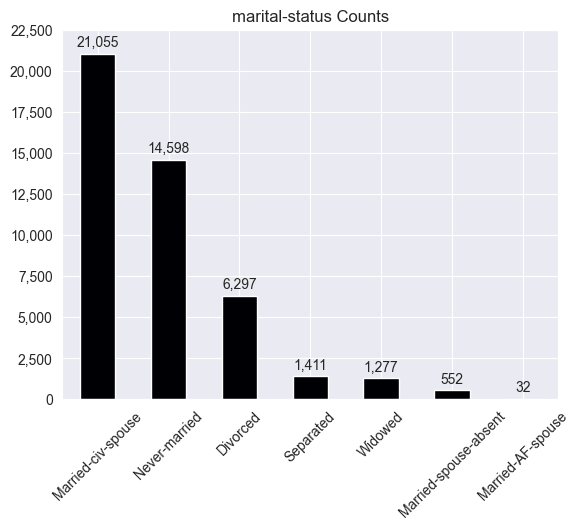

In [27]:
ax = df['marital-status'].value_counts().plot(
    kind='bar'
    , title='marital-status Counts'
    , rot=45
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['marital-status'])


`marital-status` has more of a taper from left to right compared to `workclass` and its steep drop after the most represented class. One consideration here is that we could drop the smaller categories and not lose too many rows overall.

I prefer `marital-status` to `workclass`, but we do have a better categorical feature to check out coming up.

,count,pct
occupation,,
Craft-repair,6020,0.133
Prof-specialty,6008,0.133
Exec-managerial,5984,0.132
Adm-clerical,5540,0.123
Sales,5408,0.120
Other-service,4808,0.106
Machine-op-inspct,2970,0.066
Transport-moving,2316,0.051
Handlers-cleaners,2046,0.045


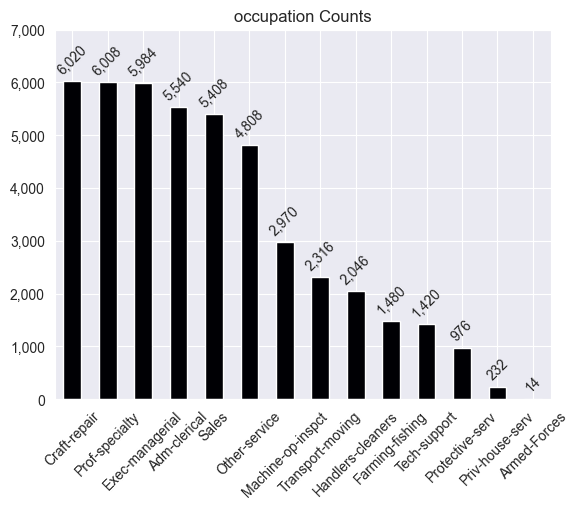

In [28]:
ax = df['occupation'].value_counts().plot(
    kind='bar'
    , title='occupation Counts'
    , rot=45
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
    , rotation=45
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['occupation'])


`occupation-counts` has more balanced representation across categories, though 14 levels would be a high amount once for one-hot encoding. There are few enough classes with smaller counts that we could look at dropping rows to remove those categories and balance this feature even further. If we go this route, we will likely drop the 3-5 categories with the smallest counts.

,count,pct
relationship,,
Husband,18666,0.413
Not-in-family,11702,0.259
Own-child,6626,0.147
Unmarried,4788,0.106
Wife,2091,0.046
Other-relative,1349,0.030


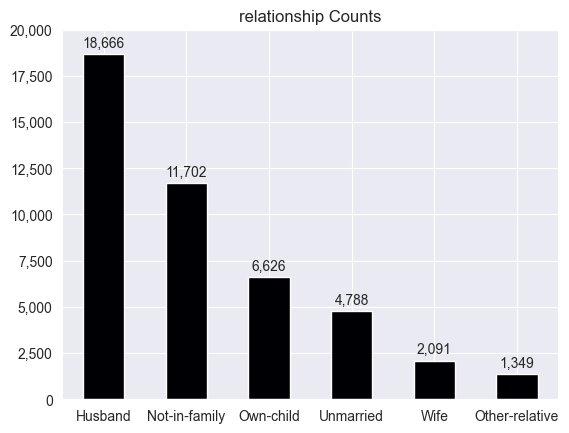

In [29]:
ax = df['relationship'].value_counts().plot(
    kind='bar'
    , title='relationship Counts'
    , rot=0
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['relationship'])


In terms of the shape of this feature, we again see a smoother taper, and the smallest class has many more rows compared to some of the other categorical features, meaning training-by-sampling may work better on this feature if we choose to explore that procedure.

We will keep `relationship` and all of its categories in our modeling dataset.

,count,pct
race,,
White,38903,0.860
Black,4228,0.093
Asian-Pac-Islander,1303,0.029
Amer-Indian-Eskimo,435,0.010
Other,353,0.008


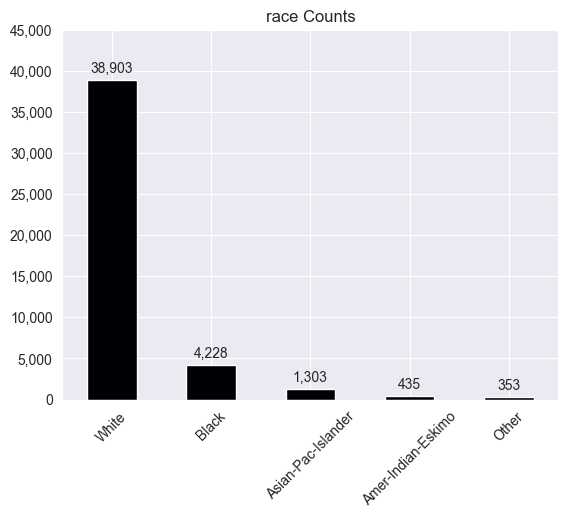

In [30]:
ax = df['race'].value_counts().plot(
    kind='bar'
    , title='race Counts'
    , rot=45
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['race'])


Similar to `workclass`, `race` has a single overrepresented category with the remaining categories not showing up much.

Our focus on synthetic data generation means we are less concerned with the meaning of any specific feature, at least at this stage of modeling, so we can look at dropping `race`, though we would reconsider this after gaining a better handle on the generative modeling since `race` captures important information in terms of meaning. We would need to look at some of the more complex procedures mentioned in the papers to handle severe class imbalance since the base dataset severely overrepresents the `White` category, this overrepresentation calling into question how this data was gathered, at least at this stage of exploration.


,count,pct
sex,,
Male,30527,0.675
Female,14695,0.325


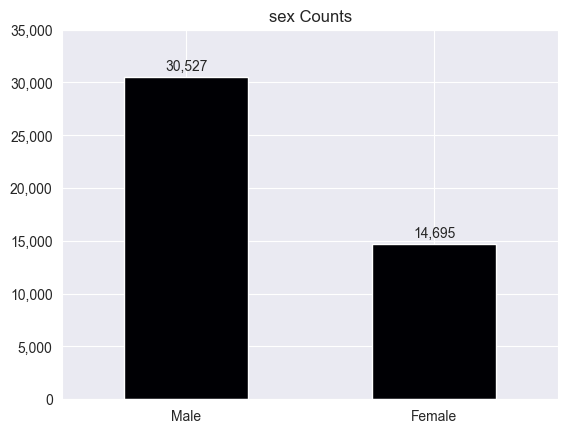

In [31]:
ax = df['sex'].value_counts().plot(
    kind='bar'
    , title='sex Counts'
    , rot=0
    , cmap='magma'
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['sex'])


We will keep `sex` in our modeling dataset since it is the only non-target binary feature. There is a noticeable class imbalance of about 2:1, and, since we only have two classes, this may be our feature to explore addressing class imbalance with, if we get that far in the modeling.

,count,pct
native-country,,
United-States,41292,0.913
Mexico,903,0.020
Philippines,283,0.006
Germany,193,0.004
Puerto-Rico,175,0.004
Canada,163,0.004
El-Salvador,147,0.003
India,147,0.003
Cuba,133,0.003


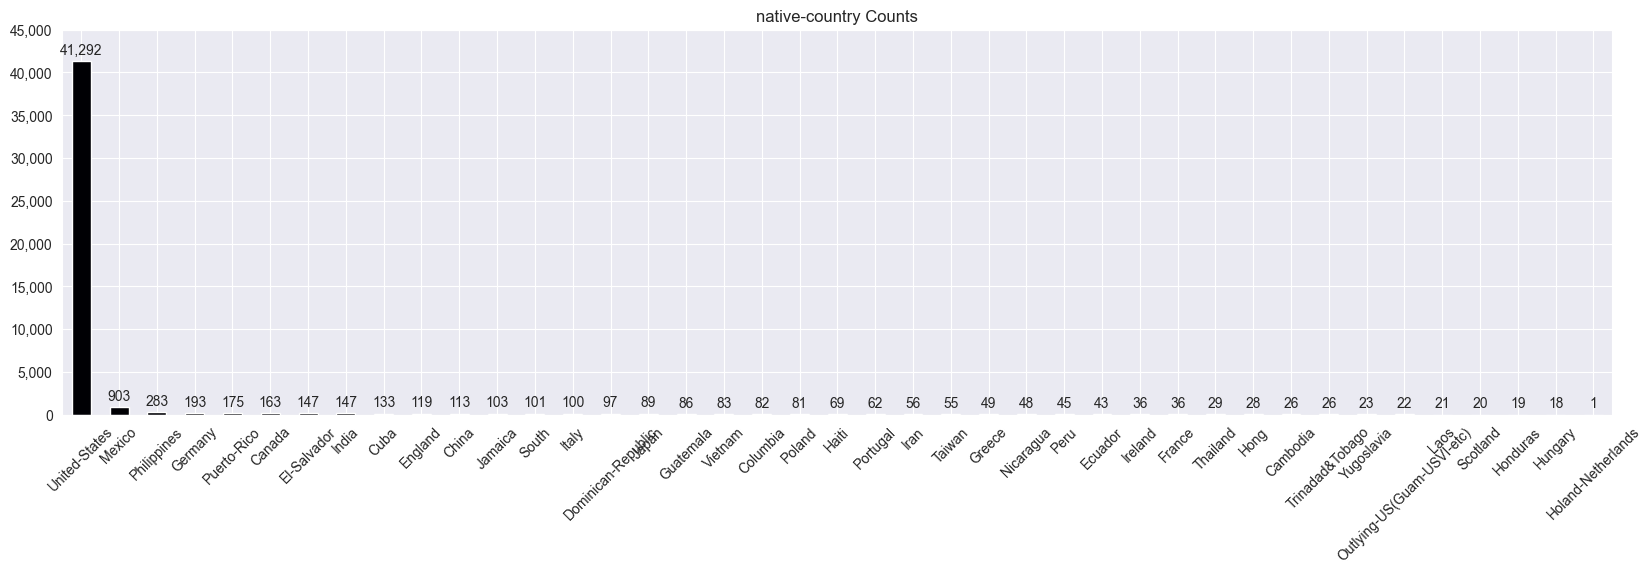

In [32]:
ax = df['native-country'].value_counts().plot(
    kind='bar'
    , title='native-country Counts'
    , rot=45
    , cmap='magma'
    , figsize=(20, 5)
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

gimme_some_counts(df['native-country'])


There are too many native countries in the dataset to be useful, and we have a severe imbalance for individuals from the United States. This feature is a good example of where one-hot encoding fails since it would create a gazillion new features, increasing the sparsity of the modeling dataset to an extreme. Even with categorical embeddings, we want to avoid this feature due to just how heavy of an imbalance we see. So, `native-country` gets dropped before modeling.

train
-------
 income
<=50K    24720
>50K      7841
Name: count, dtype: int64 

Train <=50K:  0.76 
Train >50K:  0.24


test
-------
 income
<=50K.    12435
>50K.      3846
Name: count, dtype: int64 

Test <=50K:  0.76 
Test >50K:  0.24 




Combined <=50K:  0.75 
Combined >50K:  0.25 



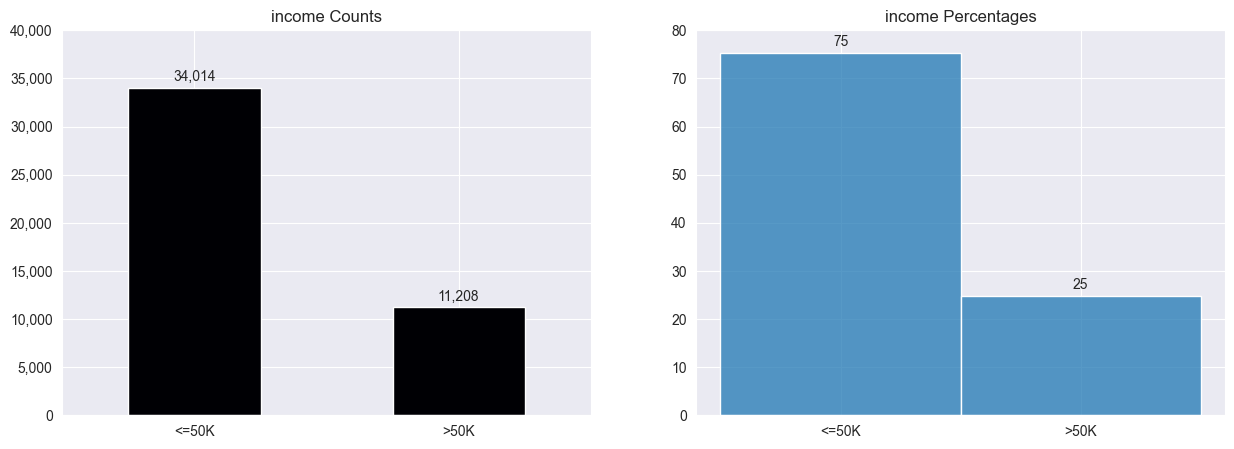

In [33]:
print(
    'train\n-------\n'
    , pd.read_csv(
        './data/adult.data'
        , names=col_names
        , skipinitialspace=True
    )['income'].value_counts()
    , f'\n\nTrain <=50K: {24720/(24720+7841): 0.2f}'
    , f'\nTrain >50K: {7841/(24720+7841): 0.2f}'
)


print(
    '\n\ntest\n-------\n'
    , pd.read_csv(
        './data/adult.test'
        , names=col_names
        , skipinitialspace=True
        , skiprows=1
    )['income'].value_counts()
    , f'\n\nTest <=50K: {12435/(12435+3846): 0.2f}'
    , f'\nTest >50K: {3846/(12435+3846): 0.2f}'
    , '\n\n'
)

print(
    f'\n\nCombined <=50K: {34014/(34014+11208): 0.2f}'
    , f'\nCombined >50K: {11208/(34014+11208): 0.2f}'
    , '\n'
)

fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

ax = df['income'].value_counts().plot(
    kind='bar'
    , title='income Counts'
    , rot=0
    , cmap='magma'
    , ax=axes[0]
)
ax.set(xlabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

ax = sns.histplot(
    df['income']
    , stat='percent'
    , ax=axes[1]
);
ax.set_title('income Percentages')
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

plt.show()


Finally, we check out the target `income` feature. While the focus of this project is not on building a supervised classification model, we will use classification to test out our synthetic data by building classification models on the real and synthetic tables. If both classification models have similar performance, then it may indicate that our synthetic data generation modeling is working.

`income` has its own class imbalance with one class being three times the size of the other, giving us a 75-25 split. The base train and test datasets that we combined above each have the same split as well. This is fine for the classification modeling we will use in this project.

### And the Winning Features Are...

Informed by the EDA above, we will keep `age` and `hours-per-week` for the continuous features, dropping `capital-gain` and `capital-loss`. I suspect that the latter two features would help in terms of classification accuracy, but they seem like they will create issues for the first passes at generative modeling due to their imbalances, with most of their values being 0s, and we will prioritize the generative modeling right now.

For discrete features, we will keep `education-num` and `sex` as our only ordinal and binary features respectively, excepting the binary target feature `income` that we will also keep for classification testing. We will also keep `occupation` and `relationship` as nominal features. The remaining discrete features have too much imbalance, especially when we have features that will be easier to work with for modeling, so we will drop the remaining discrete features. We only need a few to test out generative modeling. Once we get the modeling working, we can then extend it to handle more complicated features, including the ones we drop here.


In [34]:
print(f"occupation has {df['occupation'].value_counts().shape[0]} classes\n")

gimme_some_counts(df['occupation'])


occupation has 14 classes



,count,pct
occupation,,
Craft-repair,6020,0.133
Prof-specialty,6008,0.133
Exec-managerial,5984,0.132
Adm-clerical,5540,0.123
Sales,5408,0.120
Other-service,4808,0.106
Machine-op-inspct,2970,0.066
Transport-moving,2316,0.051
Handlers-cleaners,2046,0.045


In [35]:
print(f"relationship has {df['relationship'].value_counts().shape[0]} classes\n")

gimme_some_counts(df['relationship'])


relationship has 6 classes



,count,pct
relationship,,
Husband,18666,0.413
Not-in-family,11702,0.259
Own-child,6626,0.147
Unmarried,4788,0.106
Wife,2091,0.046
Other-relative,1349,0.030


We need to decide if we want to trim `occupation` or `relationship` down by removing a number of the smallest classes. `occupation` has 14 unique classes with 3 of those having less than 1,000 rows. Those stand out to me as a starting point for removing very small categories. To simplify, we can drop any categories that have less than 3% of the total rows, leaving us removing `Other-relative` from `relationship` as well.

Note that we have a share breakdown that we will run again after removing rows so that we can compare to what we get from the synthetic features later.


In [36]:
df.drop(
    df[
        df['occupation'].isin(['Protective-serv', 'Priv-house-serv', 'Armed-Forces'])
        | (df['relationship'].isin(['Other-relative']))
    ].index
    , inplace=True
)

In [37]:
print(f"occupation has {df['occupation'].value_counts().shape[0]} classes\n")

gimme_some_counts(df['occupation'])


occupation has 11 classes



,count,pct
occupation,,
Prof-specialty,5934,0.139
Exec-managerial,5912,0.138
Craft-repair,5875,0.138
Adm-clerical,5334,0.125
Sales,5251,0.123
Other-service,4542,0.106
Machine-op-inspct,2852,0.067
Transport-moving,2278,0.053
Handlers-cleaners,1911,0.045


In [38]:
print(f"relationship has {df['relationship'].value_counts().shape[0]} classes\n")

gimme_some_counts(df['relationship'])


relationship has 5 classes



,count,pct
relationship,,
Husband,18101,0.424
Not-in-family,11386,0.267
Own-child,6477,0.152
Unmarried,4673,0.109
Wife,2065,0.048


For binary encodings, we set the class with higher counts to 0 and the other to 1.

We rescale the ordinal `education-num` feature to fit evenly in [0,1]. The relative ordering of the categories is important, but the distance between them is not meaningful. For example, an integer distance of two compared to of one does not mean there is twice the difference between those education levels. Because of this, we want to keep the distance between categories the same, so we min-max scale instead of standardize with the continuous features later.

We one-hot encode the nominal features. As described earlier, deep learning models handle sparsity better than, for instance, GLMs. We do not have enough categories that it creates a degree of sparsity that I am worried about for the type of modeling in this project. If we find we are running into issues with input matrix sparsity, then we can pivot to categorical embeddings.

We apply the above encodings now, before creating a train-test split. We are not worried about data leakage with these encodings since we are just representing the original values differently.

Later we run a train-test split, scale the two numeric features in the train set to fit in a range of [0,1] -- the same as what we did for `education-num` above -- and then apply those standardizations to the test set. This avoids data leakage in the `MinMaxScaler()` method call. I started with standardizing the two numeric features, but I pivoted to smooshing them into the range here to that the output of the GAN generator later can run a sigmoid activation function for all the nodes in the last layer. If we were instead to standardize the continuous features here, we would need to use a linear activation function for the continuous outputs of the generator and a sigmoid activation function for the remaining features. The modeling is going to be tricky enough, so I would rather simplify there and use min-max scaling here. Also, the continuous distributions are not normal, so forcing them into a standard normal may cause unforeseen issues.


In [39]:
# Note that this cell is idempotent since we update df_encoded in place here, but only after
# recreating df_encoded from scratch at the start of the cell

# Create a copy of our main dataset to start preprocessing for modeling in particular
df_encoded = df.drop(
    columns=[
        'capital-gain'
        , 'capital-loss'
        , 'workclass'
        , 'education' # We will work with the version of this feature that is already numerically encoded
        , 'marital-status'
        , 'race'
        , 'native-country'
    ]
).reset_index(drop=True).copy()

# Encode binary features as 0s and 1s
df_encoded['sex_encoded'] = np.where(df_encoded['sex'] == 'Male', 0, 1)
df_encoded['income_encoded'] = np.where(df_encoded['income'] == '<=50K', 0, 1)

df_encoded.drop(columns=['sex', 'income'], inplace=True)

# Scale the ordinal feature
ordinal_scaler = MinMaxScaler()
df_education_num_scaled = pd.DataFrame(
    ordinal_scaler.fit_transform(df_encoded[['education-num']])
    , columns=['education-num_scaled']
)
df_encoded = pd.concat([
    df_encoded
    , df_education_num_scaled
    ], axis=1
).drop(columns=['education-num'])

# One-hot encode the two nominal features
df_encoded = pd.get_dummies(
    df_encoded
    , columns=['occupation', 'relationship']
    , dtype='int'
)


At this point, we can run a correlation matrix on the numeric features.

Looking ahead, we will use random forests for our classifiers later. Random forests are more robust to multicollinearity compared to generalized linear models (GLMs), the latter falling apart when the design matrix is non-invertible, but we still would like to know if any of our features are heavily correlated in case we run into signs of the models later having trouble handling the relationships between those features.

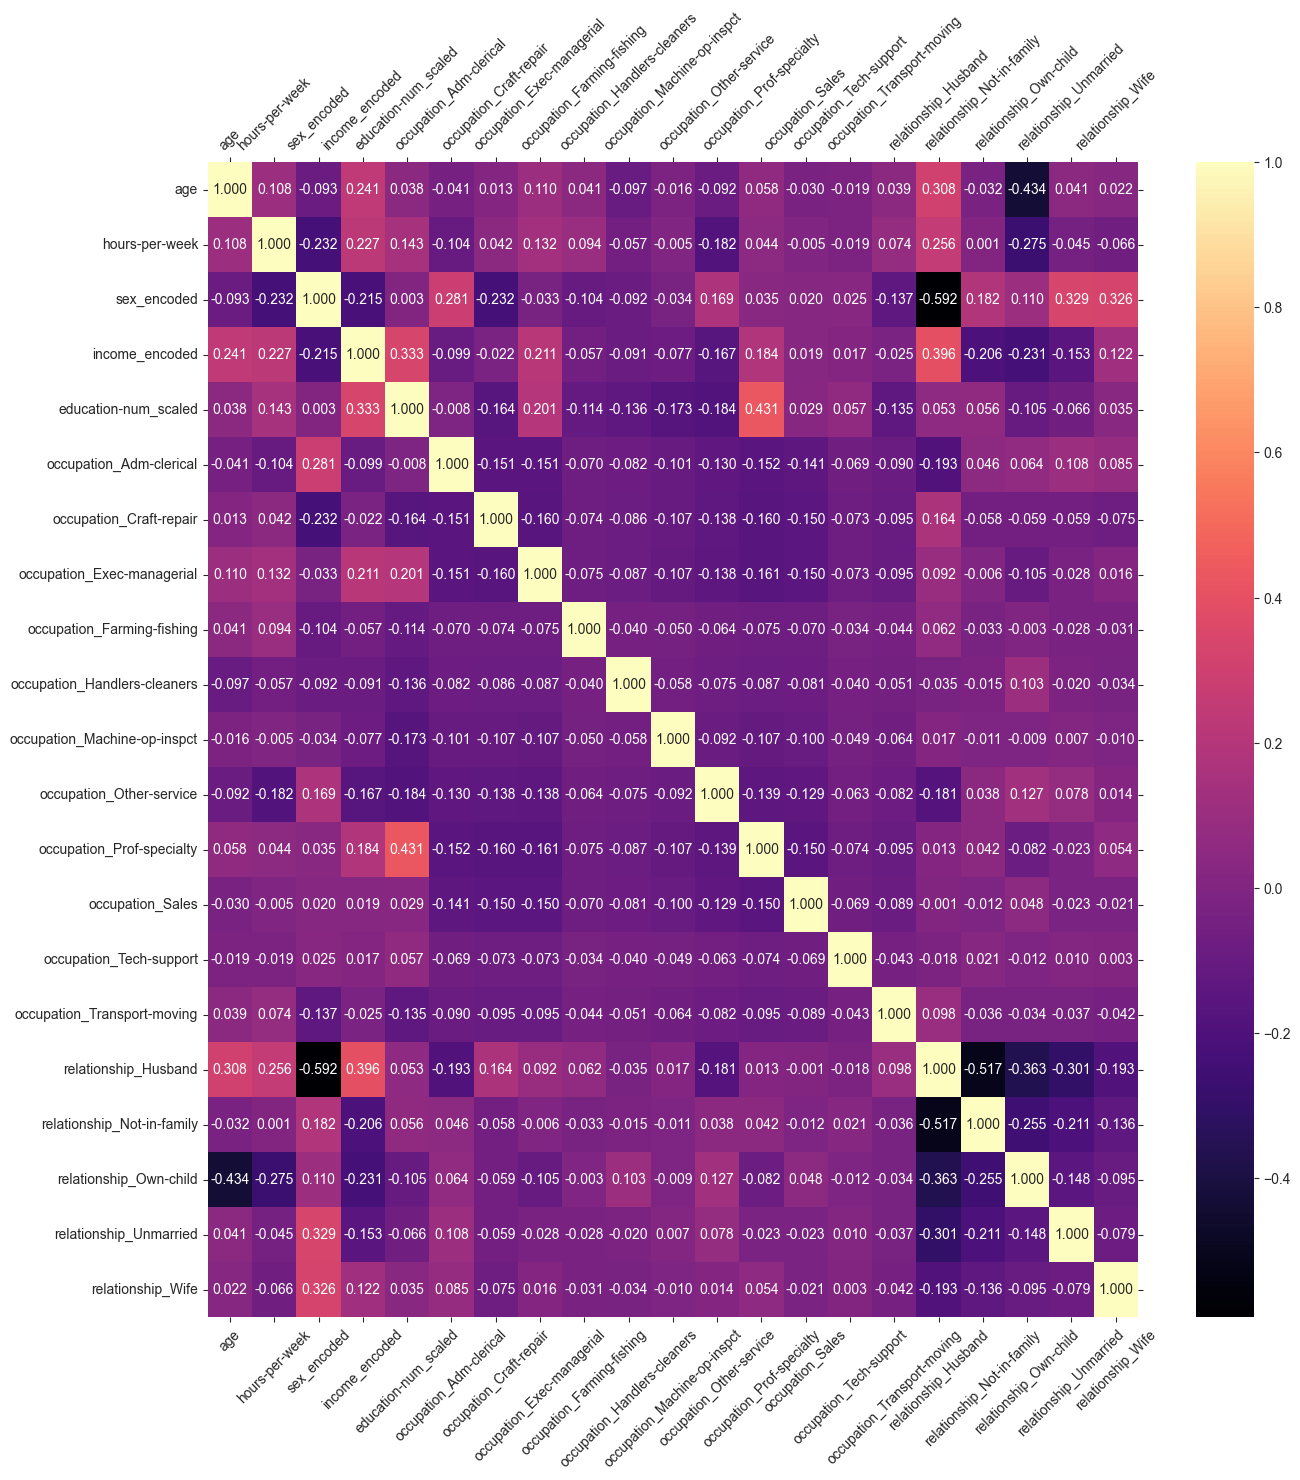

In [40]:
plt.figure(figsize=(15,15))
sns.heatmap(
    df_encoded.corr()
    , cmap='magma'
    , annot=True
    , annot_kws={'size': 10}
    , fmt='.3f'
);

plt.tick_params(
    left=True
    , top=True
    , right=True
    , bottom=True
    , labelleft=True
    , labeltop=True
    , labelright=False
    , labelbottom=True
);

plt.xticks(rotation=45);


We see some correlation with `income_encoded`. Education level stands out the most, but hours worked per week, age, and sex also show higher correlations than they do with other features in general. The occupations tend to have lower correlations with income. Relationship status is a little higher.

We see noticeable correlation between some one-hot encoded features, but none of these are high enough to worry about in terms of multicollinearity. In general, GANs are less susceptible to multicollinearity issues though not immune, but the magnitude of the correlations between features hint that we may have luck with our classifiers but not that we have two features that encode the same exact information and result in multicollinearity.

This provides some evidence that building classification models on both the real and synthetic data to compare performance later for during model evaluation should work.

Next we need to finish creating our train-test split and any remaining preprocessing. We separate out a test set here for the evaluation method later where we build classifiers on the real and synthetic data and then test their performance on this test set.

In [41]:
# Create the train-test split before scaling the numeric features
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(
    df_encoded.drop('income_encoded', axis=1)
    , df_encoded['income_encoded']
    , test_size=0.2
    , stratify=df_encoded['income_encoded'] # This keeps the 3:1 split between the income values
    , random_state=42
)

# Scale the numeric features
numeric_scaler = MinMaxScaler()
x_train_numeric_scaled = pd.DataFrame(
    numeric_scaler.fit_transform(x_train_unscaled[['age', 'hours-per-week']])
    , columns=['age_scaled', 'hours-per-week_scaled']
)
x_test_numeric_scaled = pd.DataFrame(
    numeric_scaler.transform(x_test_unscaled[['age', 'hours-per-week']])
    , columns=['age_scaled', 'hours-per-week_scaled']
)

# Combine the scaled numeric features back into the main datasets
x_train = pd.concat([
    x_train_numeric_scaled
    , x_train_unscaled.reset_index(drop=True)
    ], axis=1
).drop(columns=['age', 'hours-per-week'])
x_test = pd.concat([
    x_test_numeric_scaled
    , x_test_unscaled.reset_index(drop=True)
    ], axis=1
).drop(columns=['age', 'hours-per-week'])

print(f'Shape of x_train:\t\t{x_train.shape}')
print(f'Shape of x_test:\t\t{x_test.shape}')
print(f'Shape of y_train:\t\t{y_train.shape}')
print(f'Shape of y_test:\t\t{y_test.shape}')
print(f'Shape of df_encoded:\t{df_encoded.shape}')


Shape of x_train:		(34161, 20)
Shape of x_test:		(8541, 20)
Shape of y_train:		(34161,)
Shape of y_test:		(8541,)
Shape of df_encoded:	(42702, 21)


### Preprocessing and EDA Summary

We want most of the complexity of this project to focus on modeling, but we still want to make sure to do a thorough analysis of the data before jumping into modeling. The dataset already had some preprocessing done on it before we got our hands on it, but there were still a number of decisions to be made for our own preprocessing.

We did a bit of cleaning up invalid ? values, and then we jumped into visual inspection of each feature. We kept two numeric features with initial estimates for underlying distributions that attempt to fit the empirical data. The goal for identifying underlying distributions is in case we want to sample from random variables with those distributions as a simplified form of modeling.

For the discrete columns, we selected two binary features -- one being the target for classification -- one ordinal feature, and two nominal feature, and we encode each of them as described earlier.

The correlation matrix run on the encoded dataset is promising in terms of showing correlations with `income` that our models will hopefully pick up on during that part of generative modeling evaluation.

And, with that, we are ready to jump into modeling.


## Modeling

The complexity in implementing synthetic tabular generative models that I saw in the research papers was higher than I originally expected. Here we will try to simplify those down into some basic building blocks that we can use to make inroads into modeling, acknowledging that we need to go through these simpler steps before attempting what we see in the papers.

To repeat, our goal is to set a solid foundation and understanding of how to approach this modeling, not necessarily to create a production-ready model.

To start, we will look at a simplified approximation of one process that is mentioned in the papers along with looking at how we will evaluate the synthetic output of the models, an extra layer of evaluation that occurs after GAN training and in order to determine if the output of the GAN is real enough compared to the real data.



### Naive Independent Random Variables

Here we treat each feature as an independent random variable. For the continuous features, we use the distributions and parameters from the EDA section earlier. For the discrete features, we sample a number between 0 and 1 and use the weights for class representation to select the class.

To simplify here, we will generate data based on the full `df` dataframe, though we probably would rethink this for real implementations since we would not refit distribution parameters each time we ran a synthetic dataset. This does mean that the per-column measures of central tendency will likely be closer than if we did a split ahead of time, but we are not going to stick with this approach anyways, so it just needs to give us a foothold into the problem.

We use this starter example to demonstrate the general concept of sampling from separate random variables for each feature. The obvious issue is that the values in each feature in reality are not independent of each other, so, while the rows may look sensible from a quick scan, we do not have logic that checks for combinations of features and how they show up in the real data. Our next step here would need to be looking at the features as a joint probability distribution to capture relationships between the features, but we will instead pivot to deep learning approaches for generation instead. But this gives us a starting point.


In [42]:
n = 34000

# rvs() returns floats, so we round to the nearest integer to match ages and hours per week
gen_naive_age = np.rint(beta.rvs(a=params_age[0], b=params_age[1], loc=params_age[2], scale=params_age[3], size=n)).astype(int)
gen_naive_hours_per_week = np.rint(weibull_min.rvs(c=params_hours_per_week[0], loc=params_hours_per_week[1], scale=params_hours_per_week[2], size=n)).astype(int)

# We need to grab the values and associated weights
naive_education_num_stats = gimme_some_counts(df['education-num']).drop(columns='count')
naive_sex_stats = gimme_some_counts(df['sex']).drop(columns='count')
naive_income_stats = gimme_some_counts(df['income']).drop(columns='count')

# Due to rounding earlier, we end up at 1.001 as the sum of weights,
# so we manually adjust the most represented class down by 0.001
naive_occupation_stats = gimme_some_counts(df['occupation']).drop(columns='count')
naive_relationship_stats = gimme_some_counts(df['relationship']).drop(columns='count')

# Sum of probabilities can be different from one due to rounding in gimme_some_counts(),
# so we manually adjust here
naive_occupation_stats.loc[['Tech-support']] = naive_occupation_stats.loc[['Tech-support']] + 0.0009999999999997788
# naive_relationship_stats.loc[['Husband']] = naive_relationship_stats.loc[['Husband']] - 0.001

# Sample from the input array for each categorical feature with associated weights
gen_naive_education_num = np.random.default_rng().choice(
    naive_education_num_stats.index
    , size=n
    , replace=True
    , p=naive_education_num_stats['pct']
)

gen_naive_sex = np.random.default_rng().choice(
    naive_sex_stats.index
    , size=n
    , replace=True
    , p=naive_sex_stats['pct']
)

gen_naive_occupation = np.random.default_rng().choice(
    naive_occupation_stats.index
    , size=n
    , replace=True
    , p=naive_occupation_stats['pct']
)

gen_naive_relationship = np.random.default_rng().choice(
    naive_relationship_stats.index
    , size=n
    , replace=True
    , p=naive_relationship_stats['pct']
)

gen_naive_income = np.random.default_rng().choice(
    naive_income_stats.index
    , size=n
    , replace=True
    , p=naive_income_stats['pct']
)

# Combine
df_naive = pd.DataFrame({
    'age': gen_naive_age
    , 'hours-per-week': gen_naive_hours_per_week
    , 'education-num': gen_naive_education_num
    , 'sex': gen_naive_sex
    , 'occupation': gen_naive_occupation
    , 'relationship': gen_naive_relationship
    , 'income': gen_naive_income
    }
)

# We only show one of these to demonstrate that the weights are working as expected to match the source distribution
print(
    pd.concat(
        [
            naive_relationship_stats
            , gimme_some_counts(
                pd.DataFrame(gen_naive_relationship)
            ).drop(columns='count').reset_index().set_index(0)
        ], axis=1
    )
)
print()
print()

# Let's take a look at our brand new generated dataset, despite it not being accurate across combinations of features yet
df_naive.head()


                 pct    pct
Husband        0.424  0.428
Not-in-family  0.267  0.264
Own-child      0.152  0.152
Unmarried      0.109  0.110
Wife           0.048  0.046




,age,hours-per-week,education-num,sex,occupation,relationship,income
0,43,40,13,Female,Craft-repair,Own-child,<=50K
1,34,39,13,Female,Exec-managerial,Husband,<=50K
2,42,52,4,Male,Handlers-cleaners,Unmarried,<=50K
3,25,58,6,Male,Prof-specialty,Own-child,<=50K
4,27,35,13,Female,Craft-repair,Husband,<=50K


In [43]:
df[[
    'age'
    , 'hours-per-week'
    , 'education-num'
    , 'sex'
    , 'occupation'
    , 'relationship'
    , 'income'
]].head()

,age,hours-per-week,education-num,sex,occupation,relationship,income
0,39,40,13,Male,Adm-clerical,Not-in-family,<=50K
1,50,13,13,Male,Exec-managerial,Husband,<=50K
2,38,40,9,Male,Handlers-cleaners,Not-in-family,<=50K
3,53,40,7,Male,Handlers-cleaners,Husband,<=50K
4,28,40,13,Female,Prof-specialty,Wife,<=50K


Next we will set up our evaluative methods. As a reminder, these are the methods we saw in the papers earlier and that we would like to use for this project:

1. Per feature statistical similarity

    Inspired by the papers, we will use our own version of measuring statistics per attribute for both the real and synthetic data and compare them. For continuous features, we can calculate the mean and standard deviation. For categorical features, we can calculate cumulative distributions. The next step with this evaluation method would be to set a threshold within which we consider the synthetic data close enough to the real data, adding a parameter for that value and automating the response for if the data falls within that threshold or not.

2. Machine learning score similarity

    This evaluation metrics comes from training a classifier on the real data and the synthetic data and compare the performance. We will use a random forest classifier due to it being more robust to common issues that affect GLMs. If we find that the classification accuracy, as one example, is within a certain threshold between the two classifiers, then we will consider the synthetic data close enough to the real data. The next step here again would be to automate the comparison with the threshold value.

## Per Feature Statistical Similarity


In [44]:
# Per feature statistical similarity

# Need to update these if we add or remove columns to test out
numeric_cols = ['age', 'hours-per-week']
categorical_cols = ['education-num', 'sex', 'occupation', 'relationship', 'income']


# Displays column measures of central tendency for a pair of real and synthetic columns
def gimme_some_column_statistics(colname, synthetic_col, true_col):

    print()
    print()
    print('-----------------')
    print(f'Column stats for {colname}')
    print('-----------------\n')

    if colname in numeric_cols:
        true_mean = np.round(np.mean(true_col), 3)
        synthetic_mean = np.round(np.mean(synthetic_col), 3)
        true_std = np.round(np.std(true_col), 3)
        synthetic_std = np.round(np.std(synthetic_col), 3)

        # We can play around with putting a cap to the % difference here for good vs bad synthetic models
        percent_diff_mean = np.round(synthetic_mean/true_mean - 1, 3)
        percent_diff_std = np.round(synthetic_std/true_std - 1, 3)

        print('Mean')
        print(f'Synthetic: {synthetic_mean}')
        print(f'True: {true_mean}\n')
        print('Standard deviation')
        print(f'Synthetic: {synthetic_std}')
        print(f'True: {true_std}\n')
        print('Percent difference for synthetic/true')
        print(f'Mean: {percent_diff_mean}')
        print(f'Standard deviation: {percent_diff_std}')

    if colname in categorical_cols:
        synthetic_n = len(synthetic_col)
        synthetic_counts = pd.DataFrame(synthetic_col.value_counts())
        synthetic_counts['synthetic_pct'] = np.round(synthetic_counts['count']/synthetic_n, 3)
        synthetic_counts.drop(columns='count', inplace=True)

        true_n = len(true_col)
        true_counts = pd.DataFrame(true_col.value_counts())
        true_counts['true_pct'] = np.round(true_counts['count']/true_n, 3)
        true_counts.drop(columns='count', inplace=True)

        df_categorical_stats = pd.concat([synthetic_counts, true_counts], axis=1)
        df_categorical_stats['pct_diff'] = np.round(df_categorical_stats['synthetic_pct']/df_categorical_stats['true_pct'] - 1, 3)

        print(df_categorical_stats)


In [45]:
# Output for manual review
for column in df_naive.columns:
    gimme_some_column_statistics(column, df_naive[column], df[column])




-----------------
Column stats for age
-----------------

Mean
Synthetic: 38.397
True: 38.673

Standard deviation
Synthetic: 13.483
True: 13.131

Percent difference for synthetic/true
Mean: -0.007
Standard deviation: 0.027


-----------------
Column stats for hours-per-week
-----------------

Mean
Synthetic: 40.658
True: 41.049

Standard deviation
Synthetic: 13.03
True: 11.977

Percent difference for synthetic/true
Mean: -0.01
Standard deviation: 0.088


-----------------
Column stats for education-num
-----------------

               synthetic_pct  true_pct  pct_diff
education-num                                   
9                      0.318     0.324    -0.019
10                     0.218     0.218     0.000
13                     0.173     0.171     0.012
14                     0.059     0.058     0.017
11                     0.043     0.043     0.000
7                      0.037     0.035     0.057
12                     0.033     0.034    -0.029
6                      0.028  

## Machine Learning Score Similarity

First we will add a utility function that returns classification metrics, a confusion matrix, and a receiver operating characteristic (ROC) curve with associated area-under-the-curve (AUC) score. We covered these metrics in previous courses, so I will not go into detail on these here, but here is a quick refresher of where these metrics come from:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$
$$ Precision = \frac{TP}{TP + FP} $$
$$ Recall = \frac{TP}{TP + FN} $$
$$ F-score = 2 \times \frac{precision \times recall}{precision + recall} $$

And for ROC and AUC:

$$ True Positive Rate (Recall) = \frac{TP}{TP + FN} $$
$$ False Positive Rate = \frac{FP}{FP + TN} $$

After the utility function, we perform hyperparameter tuning against the real data. I went back and forth on doing this step, but, if it is only a matter of running hyperparameter tuning once and then sharing those parameters with the similar-enough synthetic data classifiers, then it is probably a good idea to do a little refinement on the classifier.

We use a random forest classifier for our classification algorithm. Random forest tends to be pretty robust to issues that other algorithms run into, and the focus of this project is not exploring different classification methods, so we are going with a tried-and-true approach with enough robustness to it that it should carry us through our different classification tests.

After we snag the optimized hyperparameters, we run the classifier on the real data. Note that we run hyperparameter tuning once and store the outputs in variables so we do not have to wait for a little under 7 minutes for it to run each time. We only expect these hyperparameters to change if we make changes to the real data, and we can rerun hyperparameter tuning if we do make those changes.

We will not get into this in this iteration of the project, but we only need to run classification metrics on the real data once since that data does not change throughout modeling, so we could store those metrics in variables and further automate comparison between the metrics on the real and synthetic data as a next step for this piece.

Note that we need to run the classifier on the encoded data whereas we ran the per-attribute statistics just above on the non-encoded data. This could be simplified a bit, but I think the meaning is clearer this way, so it works for now.

In [46]:
# We call y_test directly here instead of passing it as a parameter since it will not change
# throughout modeling and since we need it to calculate classification metrics for all models

def gimme_some_classification_metrics(preds, probs):
    print(f'Accuracy score: {accuracy_score(y_test, preds):.3f}')
    print(f'Precision score: {precision_score(y_test, preds):.3f}')
    print(f'Recall score: {recall_score(y_test, preds):.3f}')
    print(f'F1 score: {f1_score(y_test, preds):.3f}')

    n = len(preds)
    tn = sum([1 if y_test.iloc[i] == 0 and preds[i] == 0 else 0 for i in range(n)])
    fp = sum([1 if y_test.iloc[i] == 0 and preds[i] == 1 else 0 for i in range(n)])
    fn = sum([1 if y_test.iloc[i] == 1 and preds[i] == 0 else 0 for i in range(n)])
    tp = sum([1 if y_test.iloc[i] == 1 and preds[i] == 1 else 0 for i in range(n)])
    print(f'True negatives: {tn}')
    print(f'False positives: {fp}')
    print(f'False negatives: {fn}')
    print(f'True positives: {tp}')

    # The from_predictions() method bypasses running confusion_matrix() and passing its
    # output into ConfusionMatrixDisplay(), saving a little bit of space and complexity
    ConfusionMatrixDisplay.from_predictions(
        y_test
        , preds
        , cmap='tab10'
        , colorbar=False
        , text_kw={
            'fontsize': 15
            , 'color': 'black'
        }
    ).plot();

    fpr, tpr, thresholds = roc_curve(
        y_test
        , probs[:, 1]
    )
    auc = roc_auc_score(
        y_test
        , probs[:, 1]
    )

    plt.clf()
    plt.plot(
        fpr
        , tpr
    )
    plt.plot(
        np.arange(0, 1.1, 0.1)
        , np.arange(0, 1.1, 0.1)
    )
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(
        0.7
        , 0.2
        , f'AUC: {auc:.3f}'
    );

In [47]:
# Hyperparameter tuning

rf_clf_cv = RandomForestClassifier(random_state=42)
rf_cv_params = {
    'n_estimators': np.arange(10, 101, 5) # number of trees in the forest
    , 'min_samples_leaf': [2, 2**2, 2**3, 2**4, 2**5, 2**6] # minimum number of samples a leaf must have
}

# Commenting these out because they take ~7 minutes to run
# rf_grid = GridSearchCV(rf_clf_cv, param_grid=rf_cv_params, cv=10, verbose=1)
# rf_grid.fit(x_train, y_train)
# rf_grid.best_params_

# Output from this cell since we may not run it again unless the dataset changes
# Fitting 10 folds for each of 114 candidates, totalling 1140 fits
# {'min_samples_leaf': 8, 'n_estimators': np.int64(85)}

# cv_n_estimators = rf_grid.best_params_['n_estimators']
# cv_min_samples_leaf = rf_grid.best_params_['min_samples_leaf']
cv_n_estimators = 85
cv_min_samples_leaf = 8
rs = 42 # random state


Accuracy score: 0.834
Precision score: 0.711
Recall score: 0.583
F1 score: 0.641
True negatives: 5858
False positives: 514
False negatives: 904
True positives: 1265


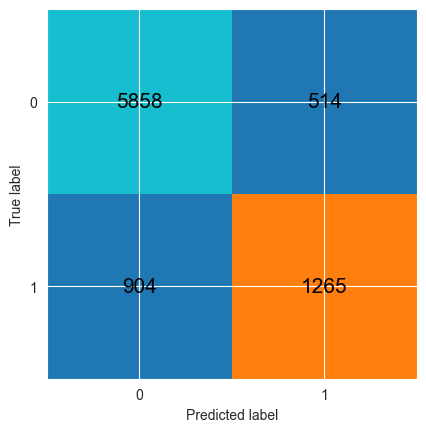

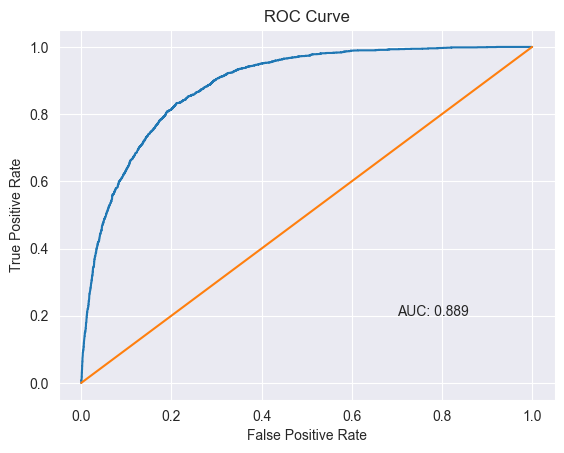

In [48]:
# Running random forest classifier on real data

clf_real = RandomForestClassifier(
    n_estimators=cv_n_estimators
    , min_samples_leaf=cv_min_samples_leaf
    , random_state=rs
)

clf_real.fit(
    x_train
    , y_train
);

y_preds_real = clf_real.predict(x_test)
y_probs_real = clf_real.predict_proba(x_test)

gimme_some_classification_metrics(
    y_preds_real
    , y_probs_real
)


In [49]:

def gimme_encoded_dataset(df_input):

    # We don't want any changes in this function to affect the input dataframes due to copy by reference
    df_temp = df_input.copy()

    # Encode binary features as 0s and 1s
    df_temp['sex_encoded'] = np.where(df_temp['sex'] == 'Male', 0, 1)
    df_temp['income_encoded'] = np.where(df_temp['income'] == '<=50K', 0, 1)

    df_temp.drop(columns=['sex', 'income'], inplace=True)

    # Scale the ordinal feature
    temp_ordinal_scaler = MinMaxScaler()
    df_temp_education_num_scaled = pd.DataFrame(
        temp_ordinal_scaler.fit_transform(df_temp[['education-num']])
        , columns=['education-num_scaled']
    )
    df_temp = pd.concat([
        df_temp
        , df_temp_education_num_scaled
        ], axis=1
    ).drop(columns=['education-num'])

    # One-hot encode the two nominal features and zero-fill features for case when dataset has no values for that category
    df_temp_one_hot = pd.get_dummies(
        df_temp
        , columns=['occupation', 'relationship']
        , dtype='int'
    )

    # One-hot encoded columns
    one_hot_encoded_cols = [
        'occupation_Adm-clerical'
        , 'occupation_Craft-repair'
        , 'occupation_Exec-managerial'
        , 'occupation_Farming-fishing'
        , 'occupation_Handlers-cleaners'
        , 'occupation_Machine-op-inspct'
        , 'occupation_Other-service'
        , 'occupation_Prof-specialty'
        , 'occupation_Sales'
        , 'occupation_Tech-support'
        , 'occupation_Transport-moving'
        , 'relationship_Husband'
        , 'relationship_Not-in-family'
        , 'relationship_Own-child'
        , 'relationship_Unmarried'
        , 'relationship_Wife'
    ]
    df_temp_one_hot = df_temp_one_hot.reindex(columns=one_hot_encoded_cols, fill_value=0)

    # Separate out target from remaining data
    x_temp = pd.concat([
        df_temp.drop(columns=['income_encoded', 'occupation', 'relationship'])
        , df_temp_one_hot
        ], axis=1
    )
    y_temp = df_temp['income_encoded']

    # Scale the numeric features
    temp_numeric_scaler = MinMaxScaler()
    x_temp_numeric_scaled = pd.DataFrame(
        temp_numeric_scaler.fit_transform(x_temp[['age', 'hours-per-week']])
        , columns=['age_scaled', 'hours-per-week_scaled']
    )

    # Combine the scaled numeric features back into the main datasets
    x_temp = pd.concat([
        x_temp_numeric_scaled
        , x_temp.reset_index(drop=True)
        ], axis=1
    ).drop(columns=['age', 'hours-per-week'])

    return x_temp, y_temp


Accuracy score: 0.746
Precision score: 0.500
Recall score: 0.000
F1 score: 0.001
True negatives: 6371
False positives: 1
False negatives: 2168
True positives: 1


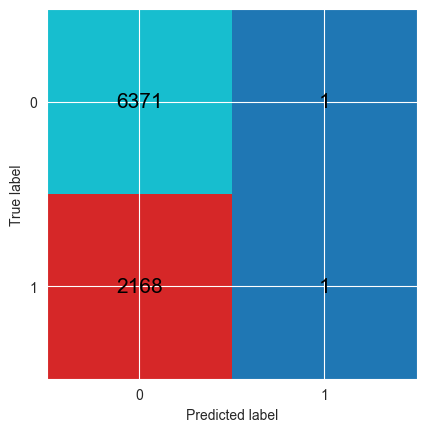

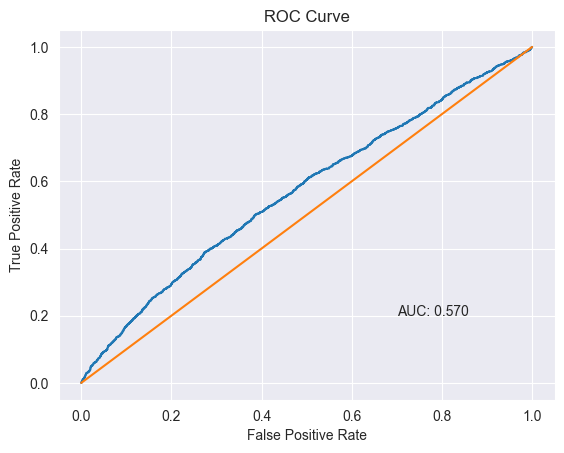

In [50]:

# Running random forest classifier on naive independent random variable data

x_naive, y_naive = gimme_encoded_dataset(df_naive)

clf_naive = RandomForestClassifier(
    n_estimators=cv_n_estimators
    , min_samples_leaf=cv_min_samples_leaf
    , random_state=rs
)

clf_naive.fit(
    x_naive
    , y_naive
);

y_preds_naive = clf_naive.predict(x_test)
y_probs_naive = clf_naive.predict_proba(x_test)

gimme_some_classification_metrics(
    y_preds_naive
    , y_probs_naive
)



As a reminder, we train the classifier on the generated data, and then we test its performance on the real test set.

And we see some garbage coming out of the classifier on the naive dataset. This makes sense in that we would not expect sampling from each independent random variable one at a time to return a meaningful predictor since there is no coherent logic to find between the features. We expect the naive classifier to favor the mean or most common category for each feature based on how we set up generating the naive data. The between-feature patterns in the real data are completely ignored in the naive data.

Interestingly, we end up with an AUC close enough to 0.5, indicating our model is statistically guessing for each prediction. This hints that there may be no one single input feature for the classification model that is a strong enough signal that it overrides the remaining features.

The output here is useful in that it confirms that we need a better approach to generative modeling. Cue the GANs.

## Let's Add Some Complexity

Now it is time to dig into the core of this project. Just above, we saw a sample idea of what generative modeling looks like. We were able to produce output that looks similar to the real data when scanning them visually, but there is no logic between the features. The leap we will take to test out the next needed steps is to leverage GANs. Since we covered GANs in-depth in a previous project, we will skip a long summary and explanation of GANs in general and jump into our first attempt to get one working.

Note that my primary reference for figuring out how to create GANs is the TensorFlow docs for DCGAN at https://www.tensorflow.org/tutorials/generative/dcgan, emphasis on the "figuring out" portion. These docs provide an example for building a GAN that works with image data. We have to modify that to work with tabular data. My general approach is to use simpler fully connected ANNs for the generator and discriminator in place of the CNNs in the docs.

The losses were probably the most complicated part for me, but there is an explanation in the docs in the section "Define the loss and optimizers" that explains how the losses can work for our use case too. For the discriminator, the loss compares predictions on the real data to an array of 1s and predictions on the fake data to an array of 0s. The generator loss compares how the discriminator classifies the fake data with an array of 1s, 1s since the generator's goal is to create fake data that it wants the discriminator to classify as real or 1.

I do not have a great way to explain the process of getting the initial GANs working. It was largely a process of trial and error, going line-by-line through the TensorFlow DCGAN docs and determining how that line would apply to tabular data instead of image data, if applicable, and translating from CNNs running against image data to fully connected ANNs running against individual tabular rows.

### GAN-ANN, a.k.a. GAN-N, a.k.a. GANON

Our first attempt will be to build a GAN with a simpler ANN in both the generator and discriminator. We start out with fully-connected ANNs in both networks with and with leaky ReLU activations, Adam optimization for handling gradient descent, and binary cross-entropy (BCE) for the loss. The reason for using BCE is that we provide labels for real and synthetic data, and then we train the discriminator to classify both and the generator to create synthetic data that gets labeled as real and that the discriminator cannot identify as synthetic.

One issue with GANs is that they can be hard to train. We have a lot of hyperparameters to tinker with:

- Adam optimizer learning rate
- Adam optimizer decay rate
- Latent space dimensions
- Number of epochs
- Batch size
- Number of hidden layers
- Architecture of hidden layers
- Activation function


The training loop for each epoch is as follows:

- Pass a noise vector into the generator and store its output, the synthetic tabular data row(s)
- Create a set of 1s and 0s as labels for real and synthetic data respectively
- Make the discriminator weights trainable
- Train the discriminator on the real data with the real labels
- Train the discriminator on the synthetic data with the synthetic labels
- Freeze the discriminator weights
- Train the generator on the noise data and the real labels

When we run the generator, we only want to update the generator weights, so we freeze the weights in the discriminator by changing the `trainable` property on the discriminator. We pass noise a noise vector into the generator. The generator learns how to translate that noise vector into realistic output that beats the discriminator.

The GAN as a whole learns to take an input noise vector and produce data that looks real. The discriminator starts out able to determine between real and synthetic data and their associated labels, but eventually the discriminator struggles to distinguish what makes rows with 1s and 0s different. At this point, the generator is creating synthetic output that is close enough to the real data that the discriminator is unable to distinguish between the two.

Once we hit this point, we can stop training the model parameters and pass a new noise vector into the generator to receive a synthetic row. We repeat this for as many rows as we want in our new synthetic dataset and move on to evaluating the synthetic data compared to the real data with our per-attribute statistical measures and machine learning score similarity.


In [51]:

# Utility function to visualize GAN metrics
def gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss):

    disc_loss_real = [hist.history['loss'][0] for hist in hist_discriminator_loss_real]
    disc_loss_syn = [hist.history['loss'][0] for hist in hist_discriminator_loss_syn]
    disc_loss_combined = [0.5 * sum(x) for x in zip(disc_loss_real, disc_loss_syn)]
    gen_loss = [hist.history['loss'][0] for hist in hist_generator_loss]
    disc_acc_real = [hist.history['accuracy'][0] for hist in hist_discriminator_loss_real]
    disc_acc_syn = [hist.history['accuracy'][0] for hist in hist_discriminator_loss_syn]

    fig, axes = plt.subplots(
        nrows=1
        , ncols=3
        , figsize=(20, 5)
    )

    # Discriminator loss
    ax = sns.lineplot([
        disc_loss_real
        , disc_loss_syn
        , disc_loss_combined
    ], ax=axes[0]
        , palette=['cyan', 'orange', 'magenta']
        , dashes=False
    );
    ax.set_title('Discriminator Loss')
    ax.set_ylim(ymin=-0.1, ymax=1.1)
    axes[0].legend(handles=[
        Patch(color='cyan', label='Real')
        , Patch(color='orange', label='Synthetic')
        , Patch(color='magenta', label='Combined')
    ])

    # Generator loss
    ax = sns.lineplot([
        gen_loss
    ], ax=axes[1]
        , palette=['red']
        , dashes=False
    );
    ax.set_title('Generator Loss')
    ax.set_ylim(ymin=-0.1, ymax=1.1)
    axes[1].legend(handles=[
        Patch(color='red', label='Generator Loss')
    ])

    # Discriminator accuracy
    ax = sns.lineplot([
        disc_acc_real
        , disc_acc_syn
    ], ax=axes[2]
        , palette=['cyan', 'orange']
        , dashes=False
    );
    ax.set_title('Discriminator Accuracy')
    ax.set_ylim(ymin=-0.1, ymax=1.1)
    axes[2].legend(handles=[
        Patch(color='cyan', label='Real')
        , Patch(color='orange', label='Synthetic')
    ])

    plt.show()

# Utility function to print out lists of GAN metrics
def gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss):

    disc_loss_real = [hist.history['loss'][0] for hist in hist_discriminator_loss_real]
    disc_loss_syn = [hist.history['loss'][0] for hist in hist_discriminator_loss_syn]
    disc_loss_combined = [0.5 * sum(x) for x in zip(disc_loss_real, disc_loss_syn)]
    gen_loss = [hist.history['loss'][0] for hist in hist_generator_loss]
    disc_acc_real = [hist.history['accuracy'][0] for hist in hist_discriminator_loss_real]
    disc_acc_syn = [hist.history['accuracy'][0] for hist in hist_discriminator_loss_syn]

    # Discriminator Loss
    print('\nDiscriminator Loss Real')
    for i, loss in enumerate(disc_loss_real):
        print(f'Epoch {i}: {loss}')

    print('\nDiscriminator Loss Synthetic')
    for i, loss in enumerate(disc_loss_syn):
        print(f'Epoch {i}: {loss}')

    print('\nDiscriminator Loss Combined')
    for i, loss in enumerate(disc_loss_combined):
        print(f'Epoch {i}: {loss}')

    # Generator Loss
    print('\nGenerator Loss')
    for i, loss in enumerate(gen_loss):
        print(f'Epoch {i}: {loss}')

    # Discriminator Accuracy
    print('\nDiscriminator Accuracy Real')
    for i, loss in enumerate(disc_acc_real):
        print(f'Epoch {i}: {loss}')

    print('\nDiscriminator Accuracy Synthetic')
    for i, loss in enumerate(disc_acc_syn):
        print(f'Epoch {i}: {loss}')


In [52]:
# Shared hyperparameters and variables

n_train_features = x_train.shape[1] + 1
latent_space_dim = 100
n_epochs= 25
batch_size=256

# We split X and y earlier, but we want the generator to ultimately produce both, so we combine them together here
df_training_input = pd.concat([x_train, pd.DataFrame(y_train).reset_index(drop=True)], axis=1)

# Sets of 1s and 0s representing real and synthetic data labels
real_labels = np.ones((df_training_input.shape[0], 1))
synthetic_labels = np.zeros((df_training_input.shape[0], 1))

# We store the original stdout so we can connect back to it and print to it after training
original_stdout = sys.stdout


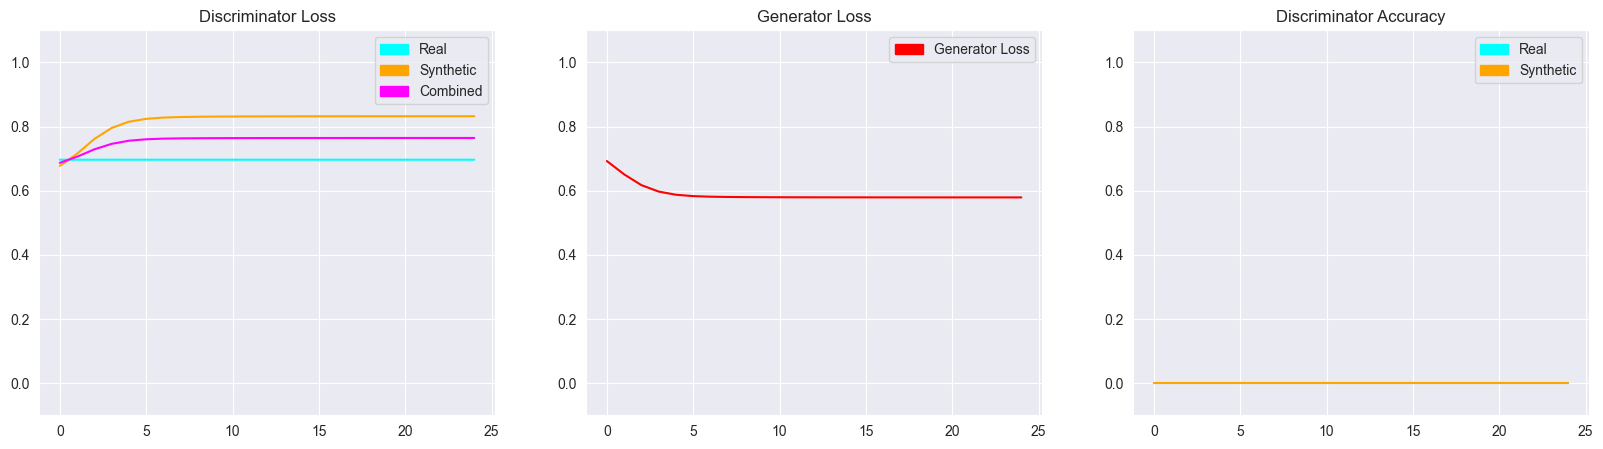

In [70]:

# GAN-ANN

###############################
# Model Definition and Creation
###############################

# Keras throws a warning to use this Adam class on apple silicon
ganon_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001, beta_1=0.5)
ganon_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001, beta_1=0.5)
ganon_generator_loss = losses.BinaryCrossentropy(from_logits=True)
ganon_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

# GAN-ANN generator and discriminator model architectures
ganon_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.LeakyReLU() # Note that the default negative slope value param is 0.3
    , layers.Dense(256)
    , layers.LeakyReLU()
    , layers.Dense(512)
    , layers.LeakyReLU()
    # We use sigmoid activation here since each feature that the discriminator evaluates has been scaled to [0,1] in the real data
    , layers.Dense(n_train_features, activation='sigmoid')
])

ganon_discriminator = models.Sequential([
    layers.Dense(512, input_dim=n_train_features)
    , layers.LeakyReLU()
    , layers.Dense(256)
    , layers.LeakyReLU()
    , layers.Dense(128)
    , layers.LeakyReLU()
    , layers.Dense(1, activation='sigmoid')
])

# We only want the discriminator weights to update when training the discriminator, so we will
# make them trainable or not manually as needed
ganon_discriminator.trainable = False
ganon = models.Sequential([ganon_generator, ganon_discriminator])
ganon_discriminator.compile(loss=ganon_discriminator_loss, optimizer=ganon_discriminator_optimizer, metrics=['accuracy'])
ganon.compile(loss=ganon_generator_loss, optimizer=ganon_generator_optimizer)

# ganon.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

# Send the tensorflow per-batch logging to devnull to silence it
sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    # We pass noise into the generator, and it translates that noise from the latent space to the learned output space.
    # We make a point to put this inside the per-epoch training loop to fit with this noise being random on each run.
    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))

    # Generates the synthetic tabular data output (this is what we snag after training)
    # synthetic_dataset = ganon_generator.predict(noise_matrix)
    synthetic_dataset = ganon_generator(noise_matrix)

    ganon_discriminator.trainable = True
    discriminator_loss_real = ganon_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = ganon_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    ganon_discriminator.trainable = False
    generator_loss = ganon.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

# Set stdout back to the original so we can print out the custom logging
sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


We have our first generative model working. Next we need to determine how good of a job it is doing. Eventually we will use the evaluation methods discussed earlier to compare synthetic datasets, but, for now we need to stabilize training in the first GAN.

GANs are notorious for their difficulty to train. The nature of GANs is that there is a version of a zero-sum game between the generator and discriminator, so we run into difficulty in the balance of how to get both models to improve in the right ways during training. Our goal is to see all losses decrease except that we eventually need the generator loss to decrease while the discriminator loss on the synthetic data starts to increase.

We expect the accuracy for the discriminator to start higher since it can easily distinguish between real and synthetic data early on when the generator cannot create real enough synthetic data. At some point during training, we need the generator to overtake the discriminator. As both networks improve, we expect that the discriminator will begin to struggle in distinguishing between the real and synthetic data. That point is where we see the discriminator accuracy start to drop off. Over time, we expect the discriminator accuracy for synthetic data to move closer to 0.5 due to its difficulty in classifying the synthetic data. We expect the accuracy against the real data to stabilize higher, but not at a perfect 1.0.

During this time, we expect to see the generator performance continue to improve. As the generator loss drops, we should see the discriminator accuracy on the synthetic data also drop, or, equivalently, see the discriminator loss on the synthetic data increase. We expect the discriminator loss on the real data to start low and stay relatively low throughout, but not at a perfect 0.0.

Our hope in this project is to try and stabilize GAN training enough that we see these patterns emerge. At that point, even if the model is not ideal, it still will let us compare a generated dataset to the original real data using the synthetic data evaluation metrics from earlier.

That said, the typical pattern we see with the model above is that the training levels off in the third or fourth epoch. The discriminator loss on the real data typically stays flat, and the discriminator loss on the synthetic data increases a bit before leveling off. During that same time period, the generator loss drops a bit and then levels off. The discriminator accuracy on the real data tends to stay flat, but the discriminator accuracy on the synthetic data can be all over the place.

What this hints at is that the GAN is doing some of what is expected on the synthetic data, but only for a short time. Unfortunately, this is the curse of working with GANs and their difficulty during training, and there are a lot of reasons for why we are seeing metrics like these. I am not really sure why the accuracy is all over the place between runs, but it is likely because the models are latching onto something early, making drastic changes in the first few epochs, and then locking into whatever they learned.

I went through the code and the docs a number of times, and I think what I wrote is correct, and that would mean we are running into typical GAN difficulties, but there is still a chance that I messed something up with coding up the models.

### Let's Make It Better

GAN training can be difficult, but we need to try improving the model. There are a number of directions we can go from here. The number of factors we can change is overwhelming, so we will use some of the recommendations in the DCGAN paper in [6] and a summary of those in https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/ to test out some changes:

- Batch normalization in both the generator and discriminator
- Use dropout in both the generator and discriminator
- ReLU in the generator and leaky ReLU in the discriminator (we used leaky ReLU in both above)
- Leaky ReLU negative slope parameter of 0.2
- Adam optimization with a learning rate of 0.0002 and a beta_1 parameter of 0.5 (we will adjust the first and keep the second the same as above)

We should call out that these recommendations are only some of those used for DCGANs, and the biggest difference is that we are not incorporating CNNs yet, so we will see if these changes end up doing any good.


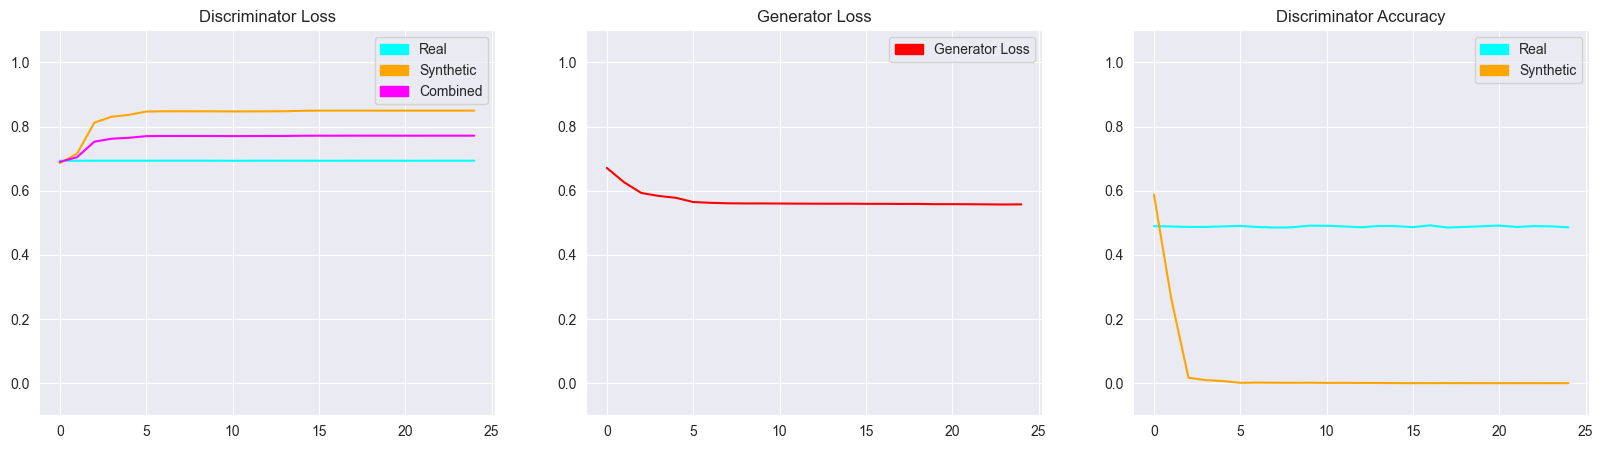

In [54]:

# GAN-ANN Attempt 2

###############################
# Model Definition and Creation
###############################

ganon2_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
ganon2_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
ganon2_generator_loss = losses.BinaryCrossentropy(from_logits=True)
ganon2_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

ganon2_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim, activation='relu')
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(256, input_dim=latent_space_dim, activation='relu')
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(512, input_dim=latent_space_dim, activation='relu')
    , layers.Dense(n_train_features, activation='sigmoid')
])

ganon2_discriminator = models.Sequential([
    layers.Dense(512, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(256)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(128)
    , layers.LeakyReLU(0.2)
    , layers.Dense(1, activation='sigmoid')
])

ganon2_discriminator.trainable = False
ganon2 = models.Sequential([ganon2_generator, ganon2_discriminator])
ganon2_discriminator.compile(loss=ganon2_discriminator_loss, optimizer=ganon2_discriminator_optimizer, metrics=['accuracy'])
ganon2.compile(loss=ganon2_generator_loss, optimizer=ganon2_generator_optimizer)

# ganon2.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = ganon2_generator(noise_matrix)

    ganon2_discriminator.trainable = True
    discriminator_loss_real = ganon2_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = ganon2_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    ganon2_discriminator.trainable = False
    generator_loss = ganon2.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)



The losses look similar to before, but the accuracies look a little bit better, though not much. The discriminator is basically guessing for real data and is getting most wrong for the synthetic data.

We will simplify the generator and add more complexity into the discriminator to see if it improves the situation.


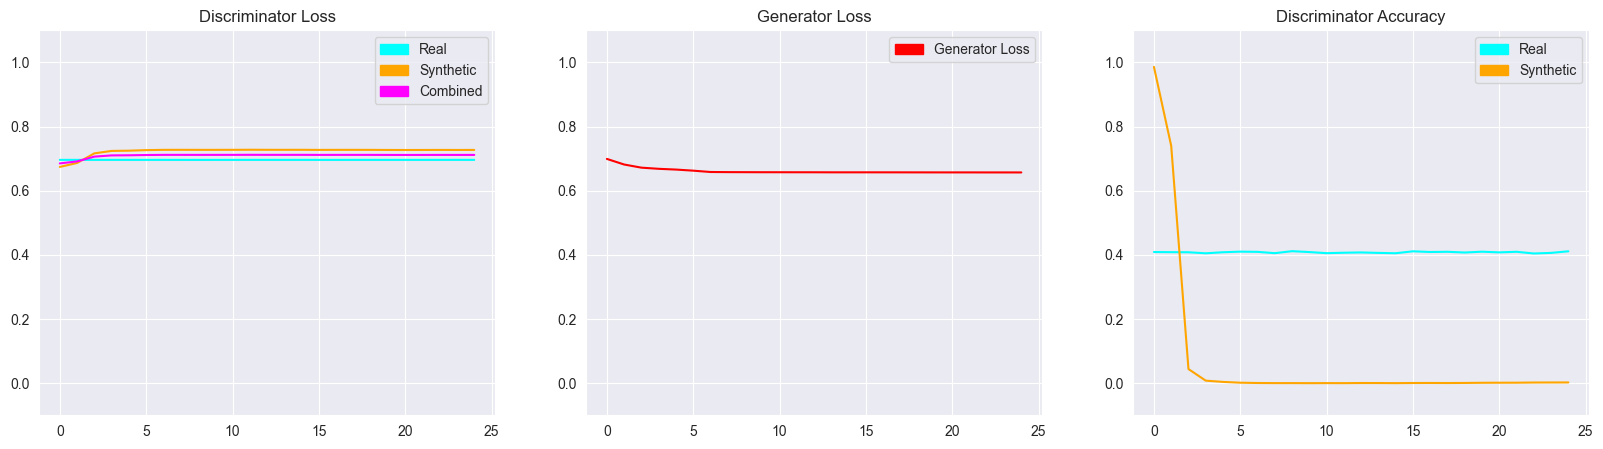

In [55]:

# GAN-ANN Attempt 3

###############################
# Model Definition and Creation
###############################

ganon3_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
ganon3_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
ganon3_generator_loss = losses.BinaryCrossentropy(from_logits=True)
ganon3_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

ganon3_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim, activation='relu')
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(512, input_dim=latent_space_dim, activation='relu')
    , layers.Dense(n_train_features, activation='sigmoid')
])

ganon3_discriminator = models.Sequential([
    layers.Dense(2048, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dense(1024, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dense(512, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(256)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(128)
    , layers.LeakyReLU(0.2)
    , layers.Dense(1, activation='sigmoid')
])

ganon3_discriminator.trainable = False
ganon3 = models.Sequential([ganon3_generator, ganon3_discriminator])
ganon3_discriminator.compile(loss=ganon3_discriminator_loss, optimizer=ganon3_discriminator_optimizer, metrics=['accuracy'])
ganon3.compile(loss=ganon3_generator_loss, optimizer=ganon3_generator_optimizer)

# ganon3.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = ganon3_generator(noise_matrix)

    ganon3_discriminator.trainable = True
    discriminator_loss_real = ganon3_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = ganon3_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    ganon3_discriminator.trainable = False
    generator_loss = ganon3.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


Same issues as last time.

Since all the action happens by the third or fourth epoch, it may be that the networks learn whatever they are going to learn too quickly. We can try slowing the learning down with the optimizer learning rates. We will up the number of epochs to give the slower learning rate time to kick in.

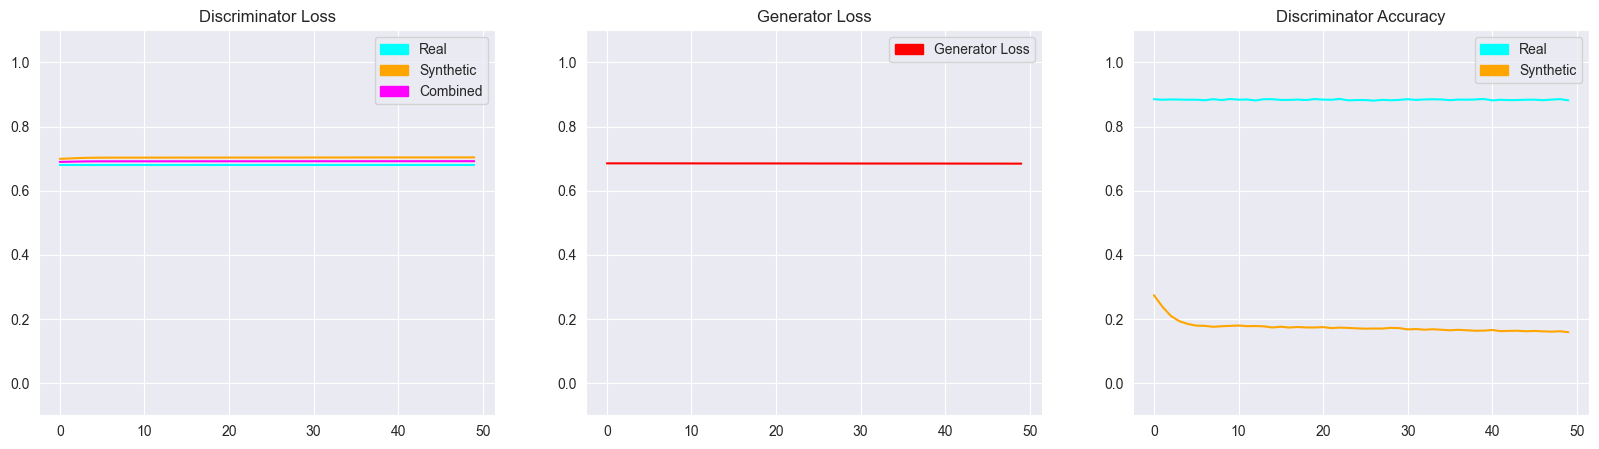

In [56]:

# GAN-ANN Attempt 4

###############################
# Model Definition and Creation
###############################

ganon4_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0000002, beta_1=0.5)
ganon4_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0000002, beta_1=0.5)
ganon4_generator_loss = losses.BinaryCrossentropy(from_logits=True)
ganon4_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

ganon4_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim, activation='relu')
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(512, input_dim=latent_space_dim, activation='relu')
    , layers.Dense(n_train_features, activation='sigmoid')
])

ganon4_discriminator = models.Sequential([
    layers.Dense(2048, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dense(1024, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dense(512, input_dim=n_train_features)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(256)
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Dropout(0.2)
    , layers.Dense(128)
    , layers.LeakyReLU(0.2)
    , layers.Dense(1, activation='sigmoid')
])

ganon4_discriminator.trainable = False
ganon4 = models.Sequential([ganon4_generator, ganon4_discriminator])
ganon4_discriminator.compile(loss=ganon4_discriminator_loss, optimizer=ganon4_discriminator_optimizer, metrics=['accuracy'])
ganon4.compile(loss=ganon4_generator_loss, optimizer=ganon4_generator_optimizer)

# ganon4.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs*2):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = ganon4_generator(noise_matrix)

    ganon4_discriminator.trainable = True
    discriminator_loss_real = ganon4_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = ganon4_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    ganon4_discriminator.trainable = False
    generator_loss = ganon4.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


Interestingly, the accuracy for the real data looks more reasonable now, though the accuracy for the synthetic data and the losses are confusing. It still looks like the models adjust some in the first few epochs and then stay relatively static throughout the rest of training.

Honestly, I am not sure what to do to get these working better. I think back to the amount of complexity in the research papers. One thing that stood out to me while doing a literature review was that the approaches to synthetic tabular data generative modeling had layers upon layers of complexity. There were specific preprocessing steps to get tabular data of different types into a singular modeling dataset. There were typically multiple custom losses meant to address the different kinds of problems inherent in this type of modeling. Some even went so far as to introduce extra losses that actually looked like sub-models, one example being to incorporate an extra classifier inside a GAN in order to predict appropriate one-hot encoded-ish representations of the categorical data using the remaining features as inputs.

This is all to say that we knew that this modeling problem would be hard before starting it, and none of the research that I reviewed used models as simple as multilayer perceptrons (MLPs) or simple-ish ANNs without moving into CNNs, RNNs, or other approaches with extra layers to them.

So, we will move on to testing out a more complicated approach. But first, we will test the two larger evaluative method for a sample generated dataset using the previous model.


In [57]:
noise_matrix = np.random.uniform(0, 1, size=(n, latent_space_dim))
generated_ganon_encoded = ganon4_generator(noise_matrix)

df_generated_ganon_raw = pd.DataFrame(
    generated_ganon_encoded
    , columns=x_train.columns.tolist() + [y_train.name]
)


The generated dataset is fully encoded, and we need to undo the encodings and scalings to get back to the format of the original preprocessed dataset. This allows us to run the per-feature statistics and classifier for evaluation between the real and generated data.

Note that the output of the generative model is continuous numbers across all the features, an obvious issue. Ideally we would train the models to output the actual values in each feature in the format that we are looking for. But the extra modeling work to get the output into a format other than continuous values turns out to be much more complicated. Some of the research papers speak about ways to concatenate features, probably the first approach I would test out after getting the rest of the modeling working.

For now, we will manually round continuous features to integers for handling discrete values. We invert the scaling for the numeric and ordinal features. We take a detour to undo the one-hot encoding by pulling out the one-hot encoded features, identifying the highest value per row for each of the two encoded features, and then put the text labels in for each row. Note that we have more than one value in the generated data for each encoded nominal feature, a glaring problem with the output of the modeling but an issue that we will skip for this iteration of the project.

In [58]:
# Converts output of generative model back to format of base dataset

def gimme_unencoded_dataset(df_input):
    # We don't want any changes in this function to affect the input dataframes due to copy by reference
    df_temp = df_input.copy()

    df_temp['age'] = df_temp['age_scaled']
    df_temp['hours-per-week'] = df_temp['hours-per-week_scaled']
    df_temp['education-num'] = df_temp['education-num_scaled']

    # Inverse scaling for numeric features
    inverted_numeric = numeric_scaler.inverse_transform(
        df_temp[['age', 'hours-per-week']]
    )
    df_temp['age'] = np.rint(inverted_numeric[:,0]).astype(int)
    df_temp['hours-per-week'] = np.rint(inverted_numeric[:,1]).astype(int)

    # Inverse scaling for ordinal features
    inverted_ordinal = ordinal_scaler.inverse_transform(
        df_temp[['education-num']]
    )
    df_temp['education-num'] = np.rint(inverted_ordinal[:,0]).astype(int)

    # Undo binary encoding
    df_temp['sex'] = np.where(
        np.rint(df_temp['sex_encoded']).astype(int) == 0
        , 'Male'
        , 'Female'
    )
    df_temp['income'] = np.where(
        np.rint(df_temp['income_encoded']).astype(int) == 0
        , '<=50K'
        , '>50K'
    )

    # Undo one-hot encoding -- idxmax() method returns the column with the highest value for each row
    df_temp['occupation'] = df_temp.filter(items=[
        'occupation_Adm-clerical'
        , 'occupation_Craft-repair'
        , 'occupation_Exec-managerial'
        , 'occupation_Farming-fishing'
        , 'occupation_Handlers-cleaners'
        , 'occupation_Machine-op-inspct'
        , 'occupation_Other-service'
        , 'occupation_Prof-specialty'
        , 'occupation_Sales'
        , 'occupation_Tech-support'
        , 'occupation_Transport-moving'
    ]).idxmax(axis=1).str[11:]

    df_temp['relationship'] = df_temp.filter(items=[
        'relationship_Husband'
        , 'relationship_Not-in-family'
        , 'relationship_Own-child'
        , 'relationship_Unmarried'
        , 'relationship_Wife'
    ]).idxmax(axis=1).str[13:]

    return df_temp[[
        'age'
        , 'hours-per-week'
        , 'education-num'
        , 'sex'
        , 'occupation'
        , 'relationship'
        , 'income'
    ]]


In [59]:
df_generated_ganon = gimme_unencoded_dataset(df_generated_ganon_raw)
df_generated_ganon.head()


,age,hours-per-week,education-num,sex,occupation,relationship,income
0,56,73,12,Female,Sales,Unmarried,>50K
1,57,61,13,Female,Sales,Husband,>50K
2,55,68,12,Female,Sales,Own-child,>50K
3,54,64,12,Female,Sales,Not-in-family,>50K
4,39,65,12,Female,Sales,Husband,>50K


In [60]:
df_naive.head()

,age,hours-per-week,education-num,sex,occupation,relationship,income
0,43,40,13,Female,Craft-repair,Own-child,<=50K
1,34,39,13,Female,Exec-managerial,Husband,<=50K
2,42,52,4,Male,Handlers-cleaners,Unmarried,<=50K
3,25,58,6,Male,Prof-specialty,Own-child,<=50K
4,27,35,13,Female,Craft-repair,Husband,<=50K


It may not look like much, but we now have a generated dataset that matches the format of our original preprocessed input dataset. Next we will check how this dataset does with the statistical comparison across feature and when training a classifier on the generated data.

In [61]:
# Per feature statistical comparison
for column in df_generated_ganon.columns:
    gimme_some_column_statistics(column, df_generated_ganon[column], df[column])




-----------------
Column stats for age
-----------------

Mean
Synthetic: 54.232
True: 38.673

Standard deviation
Synthetic: 6.337
True: 13.131

Percent difference for synthetic/true
Mean: 0.402
Standard deviation: -0.517


-----------------
Column stats for hours-per-week
-----------------

Mean
Synthetic: 65.936
True: 41.049

Standard deviation
Synthetic: 8.949
True: 11.977

Percent difference for synthetic/true
Mean: 0.606
Standard deviation: -0.253


-----------------
Column stats for education-num
-----------------

               synthetic_pct  true_pct  pct_diff
education-num                                   
13                     0.380     0.171     1.222
12                     0.374     0.034    10.000
11                     0.133     0.043     2.093
14                     0.088     0.058     0.517
10                     0.022     0.218    -0.899
9                      0.002     0.324    -0.994
15                     0.001     0.018    -0.944
8                      0.000  

Accuracy score: 0.254
Precision score: 0.254
Recall score: 1.000
F1 score: 0.405
True negatives: 0
False positives: 6372
False negatives: 0
True positives: 2169


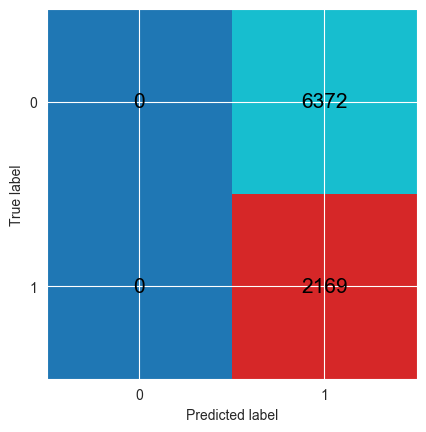

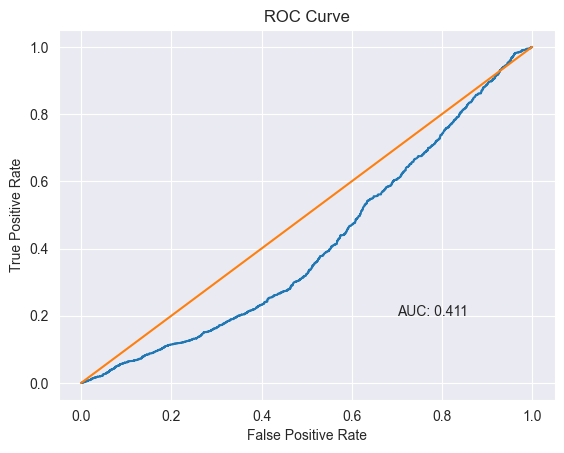

In [62]:

# Running random forest classifier on generated dataset from final GAN-ANN model

x_generated_ganon, y_generated_ganon = gimme_encoded_dataset(df_generated_ganon)

clf_generated_ganon = RandomForestClassifier(
    n_estimators=cv_n_estimators
    , min_samples_leaf=cv_min_samples_leaf
    , random_state=rs
)

clf_generated_ganon.fit(
    x_generated_ganon
    , y_generated_ganon
);

y_preds_generated_ganon = clf_generated_ganon.predict(x_test)
y_probs_generated_ganon = clf_generated_ganon.predict_proba(x_test)

gimme_some_classification_metrics(
    y_preds_generated_ganon
    , y_probs_generated_ganon
)



The statistical comparison for each feature is much farther off than what we saw with `df_naive` earlier. Most of the percentage differences for `df_naive` were less than one percent. Here we see much higher differences between the real and generated data.

The classifier does not fare better. The spread of predictions in the confusion matrix are similar to what we saw with `df_naive`, but both sets of generated data are predicting pretty much every test row as either real or fake, shown by what looks like an okay accuracy of either 75 or 25 depending on if the run predicts 1s or 0s, but we have very low F1 scores and either a low precision or low recall score. Remember from EDA earlier that `income` has a 75-25 split, and that is why we are seeing that 75% or 25% accuracy show up for both of the models built on the generated data.

We will call it a win that we were able to generate data with a GAN, but we do need to try and improve quality of that data.



### CNN-GAN, a.k.a. CANON

For everyone's sake, we will test out one more avenue for GAN modeling and then call it enough. It has taken a lot to get to this point, and we are unlikely to get these models working at a production level, so testing out one more alteration to modeling sounds like a good final step before stopping and reflecting on what we accomplished.

We will try plugging CNNs into the GANs since that seems to be the more common approach based on the research papers I reviewed. We will follow the DCGAN approach in [6] since we already started incorporating some of its changes in the GANs above.

The main change is that we will need to figure out how to add in CNNs. In the CNN project earlier in this course, we worked with image data. We trimmed those images to square regions in the center, and then we ran convolutional layers on the square input. We can look at reshaping our tabular input rows into squares and then pass convolution layers over them similar to when working with square images.

But the approach we go with is to treat the input rows as 1-dimensional data. We can then pass 1D convolution layers over them, moving horizontally across the features but not vertically.

The DCGAN paper recommends using fractional-strided convolutions in the generator and strided convolutions in the discriminator, both replacing any pooling layers. Striding is when we shift a filter by more than one step in a given direction. The effect of this is that we reduce the output of the convolutional layer. Fractional strides are strides less than one. The effect of using these is that we increase the dimensions of the output. For example, as we shift the convolutional filters over the input rows, if we use a fractional stride of 1/2, then we insert, in the case of 1D inputs, a column of 0s between each feature in the input. The convolutions learn how to fill in the 0s resulting from the upsampling. If we have 2D inputs, then we add both rows and columns of 0s.

In a sense, this is taking a base amount of features per row, adding extra blank features in between the real features, and then letting the CNN use those extra blank features as holding spots to encode the relationship between the real features. This is a way to let the CNN add complexity and then use that extra complexity to encode information that it may struggle to encode without the upsampling, making the model more complicated in a beneficial manner.


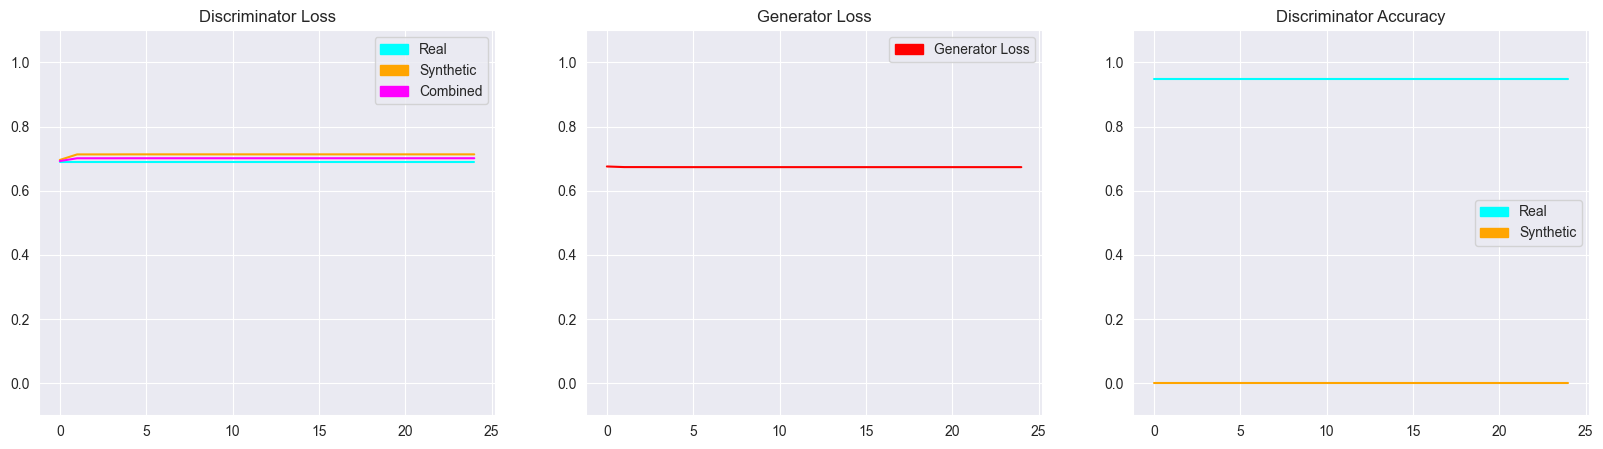

In [63]:

# CNN-GAN

###############################
# Model Definition and Creation
###############################

canon_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon_generator_loss = losses.BinaryCrossentropy(from_logits=True)
canon_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

canon_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.Reshape((1, 128))
    , layers.Conv1DTranspose(256, 5, strides=2, padding='same', activation='relu')
    , layers.Conv1DTranspose(512, 5, strides=2, padding='same', activation='relu')
    , layers.Flatten()
    , layers.Dense(n_train_features, activation='sigmoid')
])

canon_discriminator = models.Sequential([
    layers.Reshape((1, n_train_features), input_shape=(n_train_features,))
    , layers.Conv1D(128, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(256, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(512, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Flatten()
    , layers.Dense(1, activation='sigmoid')
])

canon_discriminator.trainable = False
canon = models.Sequential([canon_generator, canon_discriminator])
canon_discriminator.compile(loss=canon_discriminator_loss, optimizer=canon_discriminator_optimizer, metrics=['accuracy'])
canon.compile(loss=canon_generator_loss, optimizer=canon_generator_optimizer)

# canon.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = canon_generator(noise_matrix)

    canon_discriminator.trainable = True
    discriminator_loss_real = canon_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = canon_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    canon_discriminator.trainable = False
    generator_loss = canon.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


And we have our first CNN-based GAN working. It is not a DCGAN, but it is inspired by DCGAN.

We are again seeing training issues, similar to with the previous attempts at modeling. To repeat, this is a common pitfall with GANs, but we still would like to get at least one of these models a bit closer to performant.

For the first CNN-GAN, we see little change over time. The discriminator loss for the synthetic data increases slightly in the first epoch or two, but that is it. This means whatever state the networks set at the start do not change. At least with this model we see a more reasonable accuracy on the real data, but again we see an unexpected accuracy on the synthetic data. The discriminator is likely predicting 1s for everything it evaluates, resulting in accidentally classifying the real data right and the synthetic data wrong.

A couple of ideas stand out for improving training:

- Increasing or decreasing the learning rates for each network while letting the learning rates differ between them
- Training the discriminator or generator more frequently than the other
- Applying label smoothing by adjusting the labels from 1 and 0 to 0.9 and 0.1
- Adding in batch normalization as mentioned in the DCGAN paper
- Switching from uniform to normal distribution when creating noise matrix
- Increasing model complexity by adding more layers or more filters in either of the networks

Instead of digging into each iteration here, we will run a number of variations and put the changes in comments at the start of the code block. Hopefully we will find a modification that gives us some much-needed performance improvements.


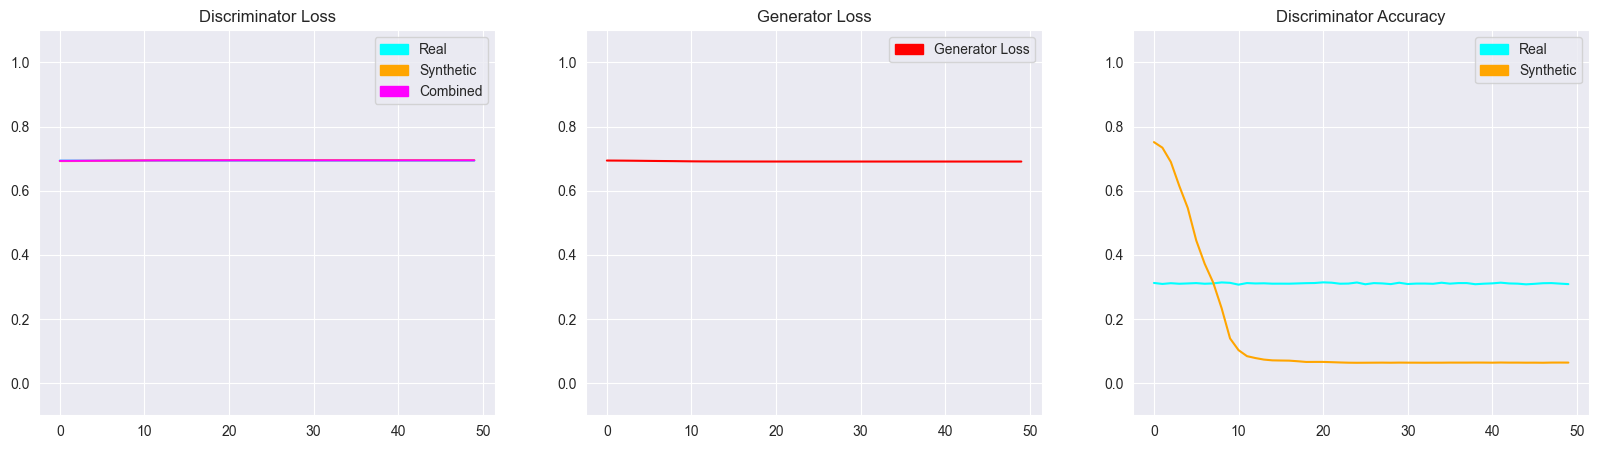

In [64]:

# Lower learning rate and a larger window size

# CNN-GAN Attempt 2

###############################
# Model Definition and Creation
###############################

canon2_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.000002, beta_1=0.5)
canon2_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.000002, beta_1=0.5)
canon2_generator_loss = losses.BinaryCrossentropy(from_logits=True)
canon2_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

canon2_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.Reshape((1, 128))
    , layers.Conv1DTranspose(256, 10, strides=2, padding='same', activation='relu')
    , layers.Conv1DTranspose(512, 10, strides=2, padding='same', activation='relu')
    , layers.Flatten()
    , layers.Dense(n_train_features, activation='sigmoid')
])

canon2_discriminator = models.Sequential([
    layers.Reshape((1, n_train_features), input_shape=(n_train_features,))
    , layers.Conv1D(128, 10, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(256, 10, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(512, 10, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Flatten()
    , layers.Dense(64)
    , layers.LeakyReLU(0.2)
    , layers.Dropout(0.5)
    , layers.Dense(1, activation='sigmoid')
])

canon2_discriminator.trainable = False
canon2 = models.Sequential([canon2_generator, canon2_discriminator])
canon2_discriminator.compile(loss=canon2_discriminator_loss, optimizer=canon2_discriminator_optimizer, metrics=['accuracy'])
canon2.compile(loss=canon2_generator_loss, optimizer=canon2_generator_optimizer)

# canon2.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = canon2_generator(noise_matrix)

    canon2_discriminator.trainable = True
    discriminator_loss_real = canon2_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = canon2_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    canon2_discriminator.trainable = False
    generator_loss = canon2.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


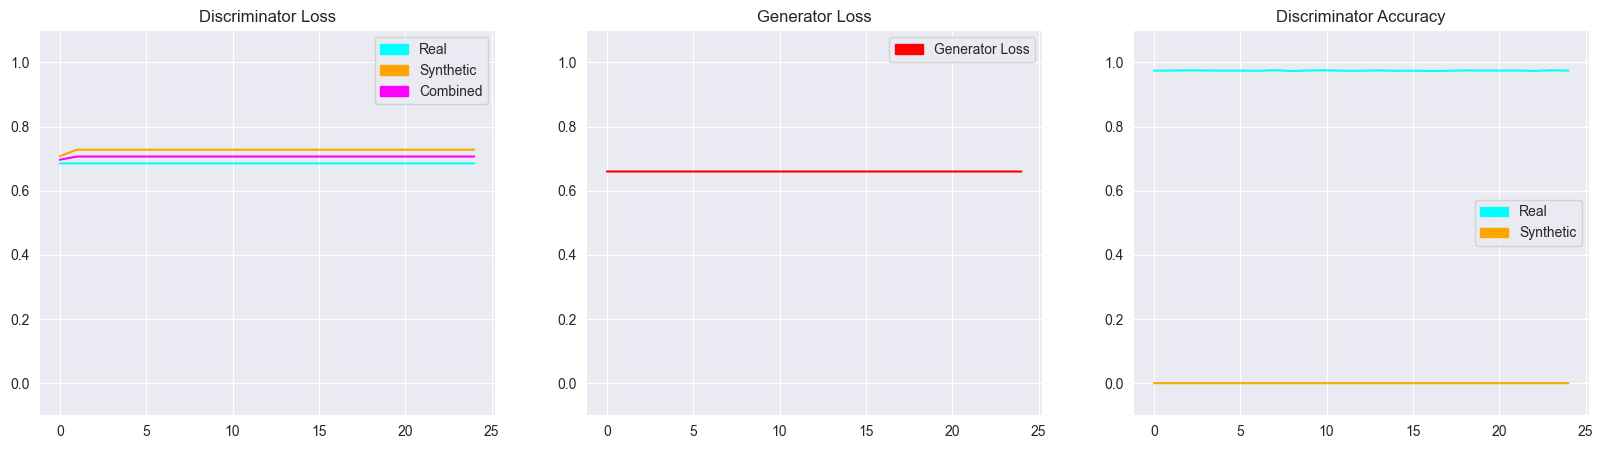

In [65]:

# Training the generator more frequently

# CNN-GAN Attempt 3

###############################
# Model Definition and Creation
###############################

canon3_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon3_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon3_generator_loss = losses.BinaryCrossentropy(from_logits=True)
canon3_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

canon3_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.Reshape((1, 128))
    , layers.Conv1DTranspose(256, 5, strides=2, padding='same', activation='relu')
    , layers.Conv1DTranspose(512, 5, strides=2, padding='same', activation='relu')
    , layers.Flatten()
    , layers.Dense(n_train_features, activation='sigmoid')
])

canon3_discriminator = models.Sequential([
    layers.Reshape((1, n_train_features), input_shape=(n_train_features,))
    , layers.Conv1D(128, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(256, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(512, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Flatten()
    , layers.Dense(64)
    , layers.LeakyReLU(0.2)
    , layers.Dropout(0.5)
    , layers.Dense(1, activation='sigmoid')
])

canon3_discriminator.trainable = False
canon3 = models.Sequential([canon3_generator, canon3_discriminator])
canon3_discriminator.compile(loss=canon3_discriminator_loss, optimizer=canon3_discriminator_optimizer, metrics=['accuracy'])
canon3.compile(loss=canon3_generator_loss, optimizer=canon3_generator_optimizer)

# canon3.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = canon3_generator(noise_matrix)

    canon3_discriminator.trainable = True
    discriminator_loss_real = canon3_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = canon3_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    canon3_discriminator.trainable = False

    generator_loss = None
    for _ in range(3):
        generator_loss = canon3.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


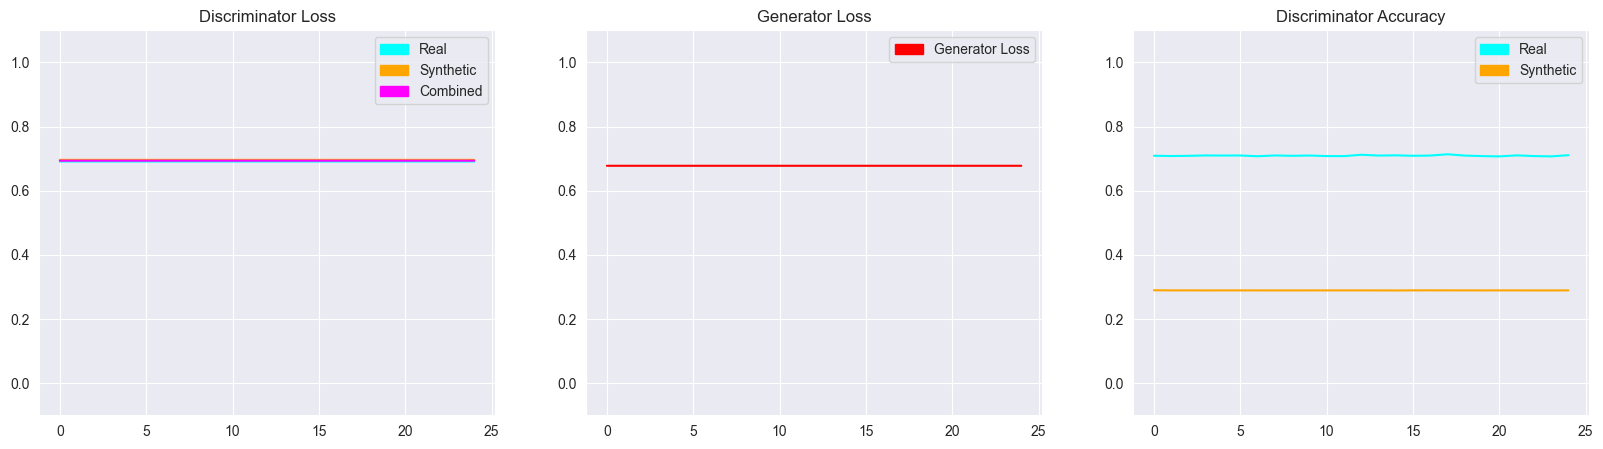

In [66]:

# Adding label smoothing and batchnorm while giving the generator more training cycles

# CNN-GAN Attempt 4

###############################
# Model Definition and Creation
###############################

canon4_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon4_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon4_generator_loss = losses.BinaryCrossentropy(from_logits=True)
canon4_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

canon4_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.Reshape((1, 128))
    , layers.Conv1DTranspose(256, 5, strides=2, padding='same', activation='relu')
    , layers.Conv1DTranspose(512, 5, strides=2, padding='same', activation='relu')
    , layers.Flatten()
    , layers.Dense(n_train_features, activation='sigmoid')
])

canon4_discriminator = models.Sequential([
    layers.Reshape((1, n_train_features), input_shape=(n_train_features,))
    , layers.Conv1D(128, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(256, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Conv1D(512, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.Flatten()
    , layers.Dense(64)
    , layers.LeakyReLU(0.2)
    , layers.Dropout(0.5)
    , layers.Dense(1, activation='sigmoid')
])

canon4_discriminator.trainable = False
canon4 = models.Sequential([canon4_generator, canon4_discriminator])
canon4_discriminator.compile(loss=canon4_discriminator_loss, optimizer=canon4_discriminator_optimizer, metrics=['accuracy'])
canon4.compile(loss=canon4_generator_loss, optimizer=canon4_generator_optimizer)

# canon4.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = canon3_generator(noise_matrix)

    canon4_discriminator.trainable = True
    discriminator_loss_real = canon4_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = canon4_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    canon4_discriminator.trainable = False

    generator_loss = None
    for _ in range(6):
        generator_loss = canon4.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)



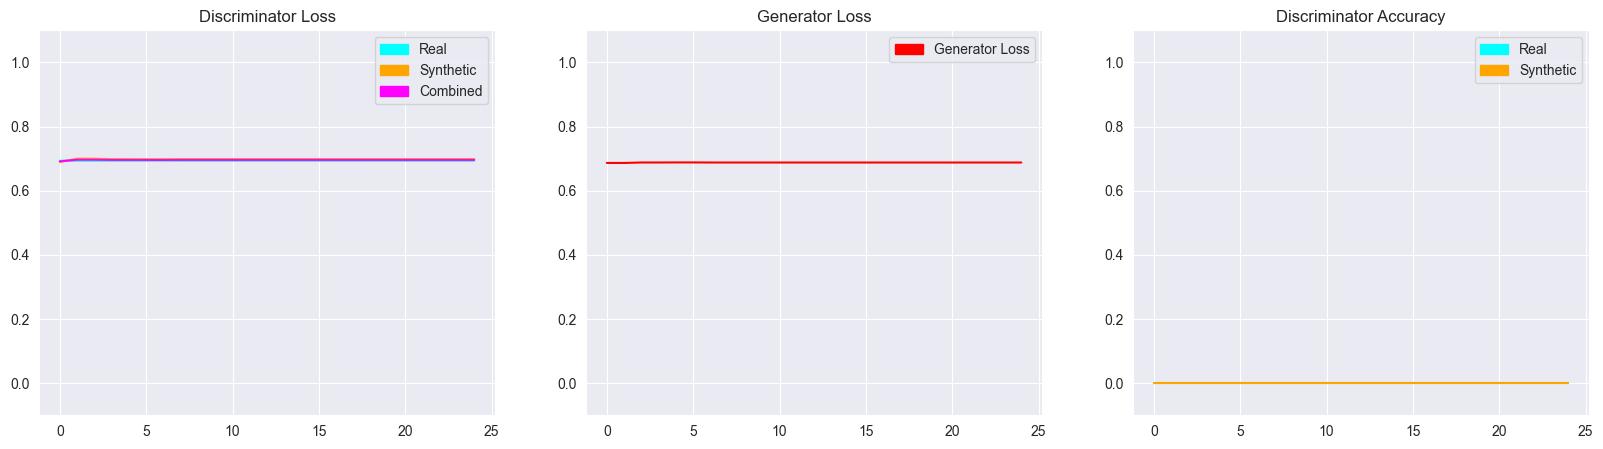

In [67]:

# Adding increased generator training loops, increased generator complexity, batchnorm, and label smoothing

# CNN-GAN Attempt 5

###############################
# Model Definition and Creation
###############################

canon5_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon5_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon5_generator_loss = losses.BinaryCrossentropy(from_logits=True)
canon5_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

canon5_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.Reshape((1, 128))
    , layers.Conv1DTranspose(256, 5, strides=2, padding='same', activation='relu')
    , layers.BatchNormalization()
    , layers.Conv1DTranspose(512, 5, strides=2, padding='same', activation='relu')
    , layers.BatchNormalization()
    , layers.Conv1DTranspose(1024, 5, strides=2, padding='same', activation='relu')
    , layers.BatchNormalization()
    , layers.Flatten()
    , layers.Dense(n_train_features, activation='sigmoid')
])

canon5_discriminator = models.Sequential([
    layers.Reshape((1, n_train_features), input_shape=(n_train_features,))
    , layers.Conv1D(128, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Conv1D(256, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Conv1D(512, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Flatten()
    , layers.Dense(64)
    , layers.LeakyReLU(0.2)
    , layers.Dropout(0.5)
    , layers.Dense(1, activation='sigmoid')
])

canon5_discriminator.trainable = False
canon5 = models.Sequential([canon5_generator, canon5_discriminator])
canon5_discriminator.compile(loss=canon5_discriminator_loss, optimizer=canon5_discriminator_optimizer, metrics=['accuracy'])
canon5.compile(loss=canon5_generator_loss, optimizer=canon5_generator_optimizer)

# canon5.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = canon5_generator(noise_matrix)

    real_labels = 0.9 * np.ones((df_training_input.shape[0], 1))
    synthetic_labels = 0.1 * np.ones((df_training_input.shape[0], 1))

    canon5_discriminator.trainable = True
    discriminator_loss_real = canon5_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = canon5_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    canon4_discriminator.trainable = False

    generator_loss = None
    for _ in range(6):
        generator_loss = canon5.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


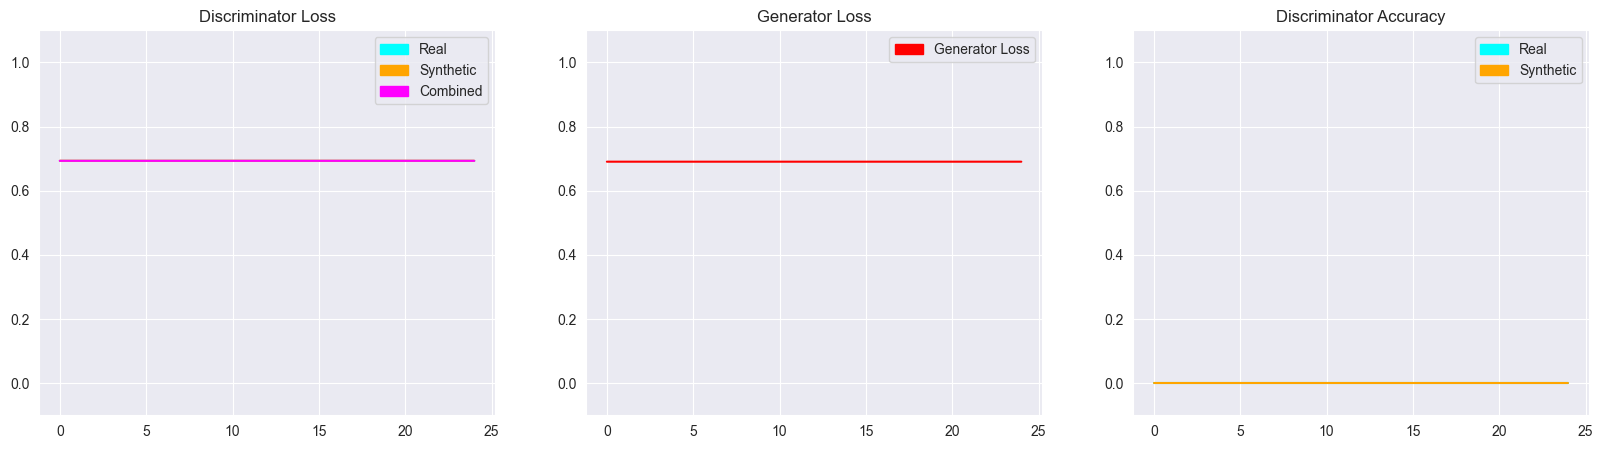

In [68]:

# Shifting the complexity back towards the discriminator

# CNN-GAN Attempt 6

###############################
# Model Definition and Creation
###############################

canon6_generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon6_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
canon6_generator_loss = losses.BinaryCrossentropy(from_logits=True)
canon6_discriminator_loss = losses.BinaryCrossentropy(from_logits=True)

canon6_generator = models.Sequential([
    layers.Dense(128, input_dim=latent_space_dim)
    , layers.Reshape((1, 128))
    , layers.Conv1DTranspose(256, 5, strides=2, padding='same', activation='relu')
    , layers.BatchNormalization()
    , layers.Conv1DTranspose(512, 5, strides=2, padding='same', activation='relu')
    , layers.BatchNormalization()
    , layers.Flatten()
    , layers.Dense(n_train_features, activation='sigmoid')
])

canon6_discriminator = models.Sequential([
    layers.Reshape((1, n_train_features), input_shape=(n_train_features,))
    , layers.Conv1D(128, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Conv1D(256, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Conv1D(512, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Conv1D(1024, 5, strides=2, padding='same')
    , layers.LeakyReLU(0.2)
    , layers.BatchNormalization()
    , layers.Flatten()
    , layers.Dense(64)
    , layers.LeakyReLU(0.2)
    , layers.Dropout(0.5)
    , layers.Dense(1, activation='sigmoid')
])

canon6_discriminator.trainable = False
canon6 = models.Sequential([canon6_generator, canon6_discriminator])
canon6_discriminator.compile(loss=canon6_discriminator_loss, optimizer=canon6_discriminator_optimizer, metrics=['accuracy'])
canon6.compile(loss=canon6_generator_loss, optimizer=canon6_generator_optimizer)

# canon6.summary()

################
# Model Training
################

hist_discriminator_loss_real = []
hist_discriminator_loss_syn = []
hist_generator_loss = []

sys.stdout = open(os.devnull, 'w')

for epoch in range(n_epochs):

    noise_matrix = np.random.uniform(0, 1, size=(df_training_input.shape[0], latent_space_dim))
    synthetic_dataset = canon5_generator(noise_matrix)

    real_labels = 0.9 * np.ones((df_training_input.shape[0], 1))
    synthetic_labels = 0.1 * np.ones((df_training_input.shape[0], 1))

    canon6_discriminator.trainable = True
    discriminator_loss_real = canon6_discriminator.fit(df_training_input, real_labels, batch_size=batch_size)
    discriminator_loss_syn = canon6_discriminator.fit(synthetic_dataset, synthetic_labels, batch_size=batch_size)

    canon4_discriminator.trainable = False

    generator_loss = None
    for _ in range(3):
        generator_loss = canon6.fit(noise_matrix, real_labels, batch_size=batch_size)

    hist_discriminator_loss_real.append(discriminator_loss_real)
    hist_discriminator_loss_syn.append(discriminator_loss_syn)
    hist_generator_loss.append(generator_loss)

sys.stdout = original_stdout

gimme_some_gan_metrics(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)
# gimme_some_gan_stats(hist_discriminator_loss_real, hist_discriminator_loss_syn, hist_generator_loss)


We test out a couple of different alterations to model hyperparameters, and we see a  little bit of change in some of the visuals, but we still do not end up with what we are hoping to see. I only show a couple of models here, but I tested out a number of other combinations of hyperparameters, none of them stabilizing GAN training enough to produce a solid generated synthetic tabular data output that can compete with the real data.

My suspicion is that the generator is overpowering the discriminator or vice versa, and that is the core problem we are running into. If we were able to get that sorted out some, then we might start to see metrics that point to other training issues. But, we will leave that as a task for future iterations.

This project is long enough at this point, and, knowing that none of the CNN-GAN models are performing better than the GAN-ANN models from earlier, we will skip running per-feature statistical comparisons and machine learning score similarity against the real data, though that would be the next step. But let us instead wrap up modeling and the project as a whole.

## Modeling Results Summary

We know that GAN training is notoriously difficult, so much so that it encourages use of alternative approaches. One takeaway here is that we ran into that training difficulty. While we were not able to get any of our GANs working at a level we were hoping for, we followed some recommended practices for how to adjust hyperparameters while trying to get GANs working.

My read on the situation is that the strength of the generators and discriminators are out of balance, and that is the core problem we would need to overcome to make further headway. I show about a dozen different configurations of models here, but I tested probably four to five dozen during the exploratory phase of modeling with no model working at levels we hoped to see.

We show one example of how we could use a generated dataset to compare against the real data. The performance in that example is not great, but it shows how we would do those comparisons after getting the GANs working.

All-in-all, I feel like this is a good attempt at a difficult problem, and it sets the groundwork for testing out a wider variety of architectures such as switching in RNNs into the GANs, pivoting to VAEs or other algorithmic approaches, widening the range of the hyperparameter space for any of these approaches, and more.


## Conclusion

To wrap things up, we tackled what I find to be a difficult technical modeling problem in creating generative models that produce tabular synthetic data. I was familiar with this modeling use case before tackling the project, but I was not clear on how to implement it, and, on that point, the project was a success in terms of understanding more about how these models work.

For modeling, I originally planned on testing out RNNs and treating each row as a sequence of features, but that was the closest I had to an approach before doing a literature review. The research papers span a wide range of approaches, and they all have long lists of caveats related to problems you run into during preprocessing and training in particular. I took the gist of what these researcher papers proposed and tried to simplify those down into vanilla GANs, and, while that sounded nice in theory, we probably do need to utilize the extra complexity in the papers to actually get this modeling working.

Like most data projects, the bulk of the code and text here is in preprocessing and EDA, but the main complexity lies in the modeling section. We decided to explore GANs, but there are alternative generative approaches that we could look at it future iterations. My next modification in future iterations would be to test out RNNs in place of CNNs in the GANs.

Fortunately, we are also in a better spot after going through the above to pick one or more of the referenced research papers and start to explore implementing those. The particular areas to keep an eye on with those are architecture choices, custom losses, and stricter preprocessing to handle different types of data with a range of statistical properties such as multi-modal continuous data.

One different preprocessing step I would explore in future iterations is switching in categorical embeddings in place of one-hot encoding for nominal features. Categorical embeddings work like word embeddings where we encode each category for a feature with an n-dimensional vector and pass embedding layers into the start of the deep learning models so that the models can learn the categorical embeddings as part of model training.

One last approach that I would like to call out is the use of conditional GANs. These allow us to pass in a desired output as part of the generator input. The main example here is passing in a particular category in a feature so the model generated a synthetic row that includes that value in that feature. I had not heard of conditional GANs before doing research for this project, and it has stuck in my head throughout working on this.

So, while we did not end up with performant GANs in relation to producing useful synthetic tabular data, I do feel good with setting a solid foundation in the basics of how to approach this type of generative modeling. It was rewarding working through the complexity of this project, particularly in picking a use case that I did not know how to tackle, doing a literature review, and then trying to reverse engineer much simpler approaches to at least get something started. Probably my biggest takeaway from this project is understanding better the complexity of generative modeling for synthetic tabular data and the amount of research and experimentation that has gone into producing production versions of this modeling, and that feels like a good place to end up.

## References

Academic papers (core to project)
- https://arxiv.org/abs/1907.00503 (Modeling Tabular Data using Conditional GAN)
- https://arxiv.org/abs/1811.11264 (Synthesizing Tabular Data using Generative Adversarial Networks)
- https://www.vldb.org/pvldb/vol11/p1071-park.pdf (Data Synthesis based on Generative Adversarial Networks)
- https://arxiv.org/abs/2303.01230v3 (Synthetic Data: Methods, Use Cases, and Risks)

Academic papers (references for project)
- https://www2.stat.duke.edu/~jerry/Papers/jos03.pdf (Multiple Imputation for Statistical Disclosure Limitation)
- https://www2.stat.duke.edu/~jerry/Papers/sm04.pdf (Simultaneous Use of Multiple Imputation for Missing Data and Disclosure Limitation)
- https://dl.acm.org/doi/10.1145/3636424 (A Survey of Generative Adversarial Networks for Synthesizing Structured Electronic Health Records)
- https://arxiv.org/abs/1609.05473 (SeqGAN: Sequence Generative Adversarial Nets with Policy Gradient)
- https://arxiv.org/abs/1611.04051 (GANs for Sequences of Discrete Elements with the Gumbel-softmax Distribution)
- https://arxiv.org/abs/1810.06640 (Adversarial Text Generation Without Reinforcement Learning)
- https://arxiv.org/abs/2403.04190v1 (Generative AI for Synthetic Data Generation: Methods, Challenges, and the Future)
- https://arxiv.org/abs/1511.06434 (Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks)

Web articles
- https://medium.com/@aldolamberti/synthetic-data-101-synthetic-data-vs-real-dummy-data-237d790433a9
- https://machinelearningmastery.com/mostly-generate-synethetic-data-machine-learning-why/
- https://towardsdatascience.com/generative-ai-synthetic-data-generation-with-gans-using-pytorch-2e4dde8a17dd
- https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-1-2b886c8cab10
- https://becominghuman.ai/generative-adversarial-networks-for-text-generation-part-3-non-rl-methods-70d1be02350b
- https://towardsdatascience.com/how-to-generate-tabular-data-using-ctgans-9386e45836a6
- https://medium.com/analytics-vidhya/a-step-by-step-guide-to-generate-tabular-synthetic-dataset-with-gans-d55fc373c8db
- https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf
- https://www.geeksforgeeks.org/gaussian-mixture-model/
- https://ocw.mit.edu/courses/18-409-algorithmic-aspects-of-machine-learning-spring-2015/e339520c4069ca5e785b29a3c604470e_MIT18_409S15_chapp6.pdf
- https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
- https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
- https://www.geeksforgeeks.org/calculating-pairwise-mutual-information-in-pandas/
- https://medium.com/@heyamit10/one-hot-encoding-vs-embedding-ca8552f60f20
- https://letsdatascience.com/synthetic-data-generation/
- https://medium.com/@halfdeb/understanding-variational-autoencoders-vaes-617a477879b5
- https://towardsdatascience.com/difference-between-autoencoder-ae-and-variational-autoencoder-vae-ed7be1c038f2
- https://keras.io/examples/generative/vae/
- https://codezup.com/hyperparameter-tuning-strategies-for-gan-loss-functions/
- https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

Primary Reference for Building GANs
- https://www.tensorflow.org/tutorials/generative/dcgan

Source code
- https://github.com/sdv-dev/TGAN
- https://github.com/sdv-dev/CTGAN

Videos
- https://www.youtube.com/watch?v=yujdA46HKwA (GANs for Tabular Synthetic Data Generation)
- https://www.youtube.com/watch?v=Ei0klF38CNs (Synthetic data generation with CTGAN)
- https://www.youtube.com/watch?v=ROLugVqjf00 (Generation of Synthetic Financial Time Series with GANs - Casper Hogenboom)
- https://www.youtube.com/watch?v=HIusawrGBN4 (What is Synthetic Data? No, It's Not "Fake" Data)
- https://www.youtube.com/watch?v=FLTWjkx0kWE (Generate Synthetic Tabular Data with GANs)
- https://www.youtube.com/watch?v=zC3_kM9Qwo0 (QuantUniversity Summer School 2020 | Generating Synthetic Data with (GANs))
- https://www.youtube.com/watch?v=9zKuYvjFFS8 (Variational Autoencoders)
- https://www.youtube.com/watch?v=qJeaCHQ1k2w (Variational Autoencoders | Generative AI Animated)



## Neural Network Background

This section covers background material that readers are likely to know having gone through this deep learning course or other supplementary information needed for understanding the research papers.

### Generative Adversarial Networks (GANs)

GANs are machine learning architectures (networks) that use competing neural networks (adversarial) that generate (generative), in this case generating synthetic data. The competing networks are the generator and discriminator. The generator takes in a noise vector as input and, initially, generates random noise. The discriminator takes in the output of the generator along with real data and distinguishes between the two, passing its labeling of real and synthetic data back to the generator. This cycle repeats again and again, each time the generator getting better at generating real-looking synthetic data and the discriminator becoming more discerning between real and synthetic data. The goal is that the generator will eventually win out and produce synthetic data that a well-refined discriminator cannot discern as different from real data. At this point, we have a generator model that we can use to produce real-enough synthetic data.

The standard objective function for GANs uses a minimax function between the generator and discriminator. The generator minimizes this loss, and the discriminator maximizes it.

One issue we may run into with GANs is mode collapse. This occurs when the generator learns to produce a small number of outputs that can trick the discriminator rather than producing throughout the entire desired output range.

#### GANs and Categorical Encodings

It is helpful to talk for a minute about how GANs interact with categorical features. GANs, as deep learning models, handle higher dimensionality in the data better than, for instance, generalized linear models (GLMs). Deep learning models use non-linear transformation and can capture a wider range of relationships in the data as compared to linear models and their need to identify linear separability in the data.

This means we can usually handle more sparse matrices after one-hot encoding categorical features where other algorithms may struggle with sparsity. This will come up later as we talk about how to encode categorical features.

One downside to sparse matrices, even with deep learning algorithms, is that they can be less memory and compute efficient. If we find that the modeling is struggling in this area, we can pivot to categorical embeddings, a method of representing categories in a categorical feature as lower-dimensional embedding representations. For example, if we have a feature with 20 categories, we can add embedding layers to the start of the deep learning models and let the models learn, say, a 5-dimensional representation for each category, similar to word embeddings that we used in the disaster tweet project. These dense embedding vectors may improve memory and compute performance. But, categorical embeddings are more complicated than one-hot encoding, so we may keep this in our back pocket in case we do run into issues with one-hot encoding.

### Convolutional Neural Networks (CNNs)

CNNs are feed-forward neural networks where we apply kernels or filters -- rectangular windows -- that slide along the dimensions of the input matrices.

For tabular data, one approach is to transform an input row into a rectangular matrix, zero padding as necessary to fill out the matrices, so we can think of the input for tabular data as appearing like an image with a width and a height and with values at each pixel. For example, if we have an input row with 13 features, we can treat that as a 1x13 vector or transform it into a 4x4 matrix and pad out the 2nd, 3rd, and 4th columns in the final row.

When we focused on images as inputs in a previous week's project, the CNN kernels summarized or abstracted elements of the images. If we added multiple kernels per layer, then each kernel would pick up on different aspects of the image. When we added multiple layers, each layer picked up on higher levels of abstraction. Note that in the CNN project we started with rectangular images with three channels and reduced those down with convolutional layers. In [1], we use "deconvolutions" or fractionally strided convolutions, and we then follow those with convolutions, the opposite direction of what we saw with the images in the previous project. We will go into the specifics for [1] below.

One aspect of CNNs to highlight is striding. Striding occurs when we slide a filter across a matrix but skip certain amounts at each step. For example, if we have a 10x10 input matrix and a 2x2 filter, without striding we would start with the filter in the upper-left of the matrix, calculate, and then shift the filter to the right by one. If we use a stride of 2, when we move that filter to the right, we skip a column and move to the second column to the right. A stride of three would skip two columns and jump to the third to the right.

For fractionally strided convolutions, we use strides that are less than 1. Strides greater than 1 reduce the output dimensions, so strides less than one increase the output dimensions. If we stride by 1/2, we add rows and columns of 0s between the rows and columns of the original matrix. This will double the dimensions of the input. We can then apply a convolution layer to the upsampled output with additional padding but with no pooling or striding to keep the dimensions of the upsampled output the same but to fill in the 0s. This process shows up as "deconvolutions" but is implemented with fractional striding in order to increase instead of decrease the dimensions of the input to that convolutional layer.

### Deep Convolutional GAN (DCGAN)

This model is explained in [6] and shows up in the architecture for [1]. DCGANs are GANs that use specific CNN architectures for both the generator and discriminator. Page 3 of the DCGAN paper has a summary list of the details for DCGAN that we will copy over here:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers. (Radford et al., 2016, p. 3)

### Recurrent Neural Networks (RNNs)

RNNs introduce recurrence, a deviation from feed-forward network architectures. CNNs are one example of feed-forward networks where the inputs get passed forward through the network but do not move sideways or backwards. In RNNs, we have recurrent layers that look sort of like hidden layers in other artificial neural networks (ANNs) but that are able to pass their output back into themselves, creating a loop in place of feed-forward hidden layers. Technically the RNN has one recurrent hidden layer, but we can think of that repeating hidden layer as unfolding into sequential hidden layers that take inputs from the previous hidden layers as well as new inputs from the tabular data. Note that the weights for the hidden recurrent layers are shared in an RNN, that being different from hidden layers in other architectures having their own separate weights.

We will cover RNNs in [2] in more detail below, but the general idea is that, for a given row, we will pass the first feature into the RNN, and then we will pass output weights from that first feature back into the RNN along with the second feature, then we will pass weights from that output back into the RNN along with the third feature, and on and on. The focus here is that we are treating features in a row like sequential inputs where each input can receive information from previous inputs. This idea of rows as sequential inputs for tabular data is interesting in opening up the possibility of using RNNs to generate tabular synthetic data.

[2] also leverages long short-term memory (LSTM), an RNN strategy to address the model forgetting from sequential elements that it saw further away from the current element. For example, if we have 50 columns to generate, we may find that the RNN remembers the previous dozen or so columns, so, once we get to column 30, the model no longer factors in the first dozen columns. This means that earlier columns may not be able to inform later columns, so we are leaving information between columns on the table. LSTMs address this by adding in ways to influence how much information a layer remembers or forgets from previous layers, the goal being to keep more impactful information from further back while dropping less impactful information from more recent elements.

### Variational Autoencoders (VAEs)

[3] references a variation on traditional VAEs.

Autoencoders (AEs) are deep learning models where we pass in an input layer, condense that input layer down to a latent space that is smaller than the input space, and then pass the encoded representation in the latent space into a decoder layer that translates the latent space into an output layer, the output layer containing a representation of the original data, trying to match the output to the input during training. We can then minimize a loss function, minimizing the mean squared error between the input layer and the output layer being one example.

AEs are doing something similar in spirit to principal component analysis (PCA), a dimensionality reduction algorithm that we studied earlier in the specialization.

VAEs are a variation on autoencoders (AEs). VAEs work similarly to AEs, but the encoder provides parameters for probability distributions instead of vectors of values in the latent space. The change with VAEs is that the encoder translates the input layer into the parameters of a probability distribution, by convention normal distributions. We then sample from the latent normal distributions to create a point in the latent space. From there, the rest of the process matches what happens in AEs.

So, the difference here is the input getting encoded into a point in the latent space compared to the parameters of a probability distribution. The issue with AEs is that the space between encoded points in the latent space is usually meaningless, so sampling a point that the AE did not see during training results in nonsensical output. VAEs overcome this since sampling from the probability distribution puts our sample in the ballpark of points seen during training but with enough randomness that we can generate new outputs that were not in the input training data.

We did not study VAEs in this class, but I thought about exploring them for this project since they, along with GANs, are the two most salient deep learning generative approaches for our goals here. But, as we will repeat throughout the project, I am worried about scope creep, so we will keep VAEs as a backup in the situation that GANs give us too much trouble.


## Research Paper Summaries

The first three papers at the start of the notebook present different approaches to generating tabular synthetic data. All three use GANs for the generative aspect of their architectures. [1] and [2] come earlier than [3] and have slightly simpler architectures, though those implementations are still complicated. [3] comes later and looks more effective than [1] and [2], but it introduces an extra layer of complexity with a conditional GAN and more complicated normalization for continuous columns.

For terminology, we will refer to the model in [1] as table-GAN, in [2] as TGAN, and in [3] as CTGAN.

Each paper has some level of review of other methods for preserving privacy and utility. The papers cover many areas related to risk, exposure, and competing methods. Our focus is on seeing how far we can get in implementing generative models, so we will skip recaps of other information from the papers.


### [1] Data Synthesis Based on Generative Adversarial Networks

This paper introduces table-GAN, a CNN approach to generation. table-GAN handles categorical, discrete, and continuous data but leaves out other types of data such as time-series data (Park et al., 2018, p. 1071). table-GAN consists of three ANNs:
1. Generator
2. Discriminator
3. Classifier (Park et al., 2018, p. 1072)

The first two ANNs are standard in GANs, and table-GAN leverages DCGAN in particular for these two. DCGAN is a form of CNN, so we will need to prepare the data so that a CNN can run on it. The classifier is a new addition that checks for "semantic integrity," learning what combinations of values in different columns are legitimate so we do not end up with a nonsensical combination such as generating the city of Boulder in the state of Kansas (Park et al., 2018, p. 1072).

table-GAN includes three loss functions:
1. The standard GAN objective function
2. Information loss. This takes the mean and standard deviation for each feature, making sure that synthetic rows have the same statistical properties as real rows. The goal is for this loss to be 0 for both mean and standard deviation, indicating that the discriminator may not be able to distinguish between the real and synthetic data. The paper uses an exponentially weighted moving average to approximate the mean and standard deviation for each feature.
3. Classification loss. This maintains semantic integrity by predicting one feature by the other features, the loss being the discrepancy between the prediction by the classifier and what is produced by the generator. (Park et al., 2018, p. 1075-6)

The discriminator uses the standard loss, the classifier uses classification loss, and the generator uses all three losses.

table-GAN utilizes three evaluation metrics:
1. Distance to the closest record (DCR). DCR calculates the Euclidean distance between a synthetic record and the closest real record, applying attribute-wise normalization so that each attribute contributes equally to the distance. DCR = 0 leaks information since the synthetic data is the same as a real record.
2. Statistical comparisons. For these, we compute per-attribute metrics and compares those between real and synthetic data. We want these to be very close.
3. Machine learning score similarity. This method trains separate classifiers or regressors on the real and synthetic tables and then checks if the F1 score for classification or the mean relative error (MRE) for regression are the same between the models trained on the real and the synthetic data. (Park et al., 2018, p. 1078)

### [2] Synthesizing Tabular Data using Generative Adversarial Networks

This paper introduces TGAN, a modeling approach that differs from [1] in:
- using RNNs instead of CNNs, using LSTM with attention in particular
- focusing on marginal distributions more than optimizing for prediction accuracy on synthetic data
- explicitly learning marginal distributions for each column by minimizing the Kullback-Leibler (KL) divergence (the KL divergence measures how different two probability distributions are) (Xu and Veeramachaneni, 2018, p. 2)

TGAN does introduce a few new ideas. It is built to handle multi-modal continuous data -- continuous data has more than one value that is the most common, visually showing up as distributions with more than one peak when plotting the distribution. Multi-modal continuous data causes issues when we use tanh to normalize to the range [-1,1]. If any of the modes are near -1 or 1, or at least not near the center or 0 for tanh, we risk running into vanishing or exploding gradients during backpropagation, similar to how these gradient issues show up for S-shaped activation functions when we are working in regions not near their center. (Xu and Veeramachaneni, 2018, p. 2-3)

TGAN's approach here is interesting and worth exploring for a moment.

TGAN applies a workaround with Gaussian kernel density estimation (KDE) and Gaussian mixture models (GMMs). Gaussian KDE is a process by which we can imagine taking a certain window of set width, sliding that window horizontally along the actual distribution of a continuous variable, and taking an average at each step of that sliding. The Gaussian portion means points that are closer to the center of the window have more weight while points further away have less weight, similar to what we see with a Gaussian distribution. (Xu and Veeramachaneni, 2018, p. 3)

GMMs are distributions that are combinations of Gaussian distributions. In this scenario, if a continuous variable has more than one mode, we can model each mode as a Gaussian distribution, and then the variable as a whole is a combination of each of those individual Gaussian distributions. So, we use GMMs to cluster each continuous random variable to estimate the number of modes. Later we can sample from the GMM. We calculate the probability that a value comes from each of the modes, and then we pick one of the modes and normalize against it. Note that the multinomial distribution we mentioned in tandem with GMMs for handling multimodal continuous variables shows up in that we can think of each mode as a factor level in the multinomial distribution. (Xu and Veeramachaneni, 2018, p. 3)

Note that we will need to use these GMMs with KDE if we are handling multimodal data.

Having addressed numerical variables, we can pivot to categorical variables. The main issue we face here is that discrete variables are not differentiable, causing backpropagation to fall apart. TGAN gets around this by one-hot encoding categorical variables and then using softmax along with adding noise to the new one-hot encoded binary variables to create differentiable units. The paper refers to this as "smoothing" categorical variables. (Xu and Veeramachaneni, 2018, p. 3)

TGAN uses the standard GAN loss for the generator but adds the KL divergence in different ways for continuous and discrete variables. The discriminator uses conventional cross-entropy loss. (Xu and Veeramachaneni, 2018, p. 4)

TGAN uses two evaluation metrics. The first is what we called machine learning score similarity when summarizing [1] above. The second is pairwise mutual information between two random variables -- the amount of information about one random variable that you can determine based on information in the other random variable. (Xu and Veeramachaneni, 2018, p. 2-3).

### [3] Modeling Tabular Data using Conditional GAN

Next we move on to CTGAN, the most complex of the approaches we look at here.

The CTGAN paper covers much of the same ground as the previous two papers in terms of setup and background context, especially [2] since it is by some of the same authors, but this paper does introduce an additional issue with severe imbalance in categorical columns. This paper also tests out tabular variational autoencoders (TVAEs), though it finds that TVAEs underperform compared to CTGANs. The paper also introduces a synthetic data benchmarking system that is open source and extensible. But, aside from those, the overall setup for CTGAN is familiar to us at this point. (Xu et al., 2019, p. 1-2)

The new problem since [2] is that highly imbalanced discrete columns result in mode collapse and a lack of representation for minority classes. CTGAN uses conditional generators and training-by-sample to address the issue of class imbalance in discrete features where a minority class shows up few enough times that the generator may not reliably learn to generate those values. (Xu et al., 2019, p. 4-5)

First we look at the role of the conditional generator. If we resample from the real data to pick up more instances of the minority class, then the generator learns a resampled distribution, not the true distribution. We instead resample evenly across classes during training and then later recover the actual distribution during test. This means we take the same number of rows for each class during training. For each of those classes, the generator learns to generate a row conditioned on that class value for that column. The generative side of this is that we pivot to a generator that generates full rows based on a new input of a given class value. The paper calls this a conditional generator and calls a GAN built on it a conditional GAN. (Xu et al., 2019, p. 4)

Implementing the conditional GAN poses a few issues:
1. We need to create a representation for the condition and develop an input for it into the model
2. The generated rows must retain the condition we pass into the generator
3. The conditional generator must learn the real conditional distribution, meaning $P_{generated}(row|class) = P_{real}(row|class)$. We can recreate the original distribution from the evenly sampled distribution we discussed in the last paragraph by multiplying by the probability of each class showing up in each column, so $P_{generated}(row|class) P(\text{class in real distribution})$. (Xu et al., 2019, p. 4)

The paper uses conditional vectors as representations for the conditions. For the conditional vector, we one-hot encode the discrete columns. For each one-hot encoded discrete column, we put a mask of 1 when the value for that column matches the right one-hot encoded column. We repeat this for each discrete column and then concatenate each of the mask vectors together to create the conditional vector, so we end up with, for example, a vector such as 000100100100110001000 capturing the categorical values for that row. (Xu et al., 2019, p. 5)

But the generator can create conditional vectors with incorrect masks, vectors where we put 1s in places where they should not be. For example, for the one-hot encoded representation for a single discrete column, the generator may provide more than one 1 for that column, an invalid one-hot encoded vector. We add a cross entropy loss between generated and real conditional vectors so that the generator ends up learning to produce only valid conditional vectors, the new addition for the generator loss. (Xu et al., 2019, p. 5)

Last, we use the training-by-sampling procedure to perform the adjusted sampling. The crux of this procedure is that we adjust the probability mass function (PMF) for classes in a given feature by taking the logarithm of each class's frequency, increasing the probability that we sample classes with smaller real probabilities. (Xu et al., 2019, p. 5)

The final new item to discuss comes during evaluation. It is worth noting that the CTGAN paper introduces a whole new benchmarking tool -- the [SDGym](https://github.com/sdv-dev/SDGym) -- that is open-source and available for use. The paper points out that other papers use different benchmarks for synthetic generation models, so standardizing on a benchmarking tool could provide better comparative insight between models. (Xu et al., 2019, p. 7)

The final note here is that this model uses yet another GAN: PacGAN, a variant of DCGAN, with DCGAN underlying the approach in [1].
